In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import os
from collections import OrderedDict
import pickle as pkl
from utils import u_plot as uplot, u_darrays as uda, u_met, u_interpolate as u_int
import pandas as pd
from metpy.calc import kinematics

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [2]:
cd .. 

/home/ck/pythonWorkspace/proj_CEH


In [4]:
def read_pdf(path, res):
    
    pdf = pkl.load(open (path, 'rb'))
  
    pdf = pdf.where((pdf.clat>=5) & (pdf.area*res**2>=10000) & (pdf.area*res**2<=150000) & (pdf.clat<=8.5) &
                    (pdf.clon>=-10) & (pdf.clon<=11) & ((pdf.month<=5) | (pdf.month>=10)))
    pdf = pdf.dropna()

    pdf.tmin = np.array(pdf.tmin, dtype=float)
    pdf.tmean = np.array(pdf.tmean, dtype=float)
    pdf['70area'] = np.array(pdf['70area'], dtype=int)
    
    return pdf
    

In [5]:
pdf = read_pdf(cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA.p', 7.7)

In [6]:
pdf_cp4 = read_pdf(cnst.CLOVER_SAVES + 'StormLoc_CP4hist_-50_5000km_WA.p', 4.4)

In [10]:
era = xr.open_dataset(cnst.ERA_DAILY_PL12UTC)
era = uda.flip_lat(era)
#era = era.sel(latitude=slice(-10,25), longitude=slice(-20,25))

In [11]:
clim = era.resample(time='M').mean('time')

/home/ck/miniconda3/lib/python3.5/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ck/miniconda3/lib/python3.5/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.107e+03, 1.970e+02, 6.100e+01, 1.600e+01, 6.000e+00, 4.000e+00,
        4.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([ 10020.01 ,  19666.493,  29312.976,  38959.459,  48605.942,
         58252.425,  67898.908,  77545.391,  87191.874,  96838.357,
        106484.84 ]),
 <a list of 10 Patch objects>)

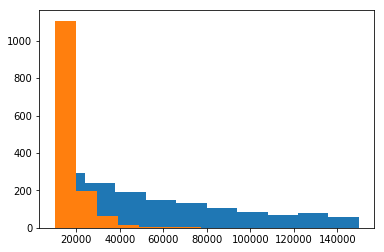

In [12]:
plt.hist(pdf.where(pdf.tmin<=np.percentile(pdf.tmin,10)).area*7.7**2)  # stronger
plt.hist(pdf.where(pdf.tmin>=np.percentile(pdf.tmin,90)).area*7.7**2)  # weaker

/home/ck/miniconda3/lib/python3.5/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ck/miniconda3/lib/python3.5/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([273.,  81.,  42.,  12.,  11.,   5.,   4.,   2.,   0.,   1.]),
 array([10009.12, 14413.52, 18817.92, 23222.32, 27626.72, 32031.12,
        36435.52, 40839.92, 45244.32, 49648.72, 54053.12]),
 <a list of 10 Patch objects>)

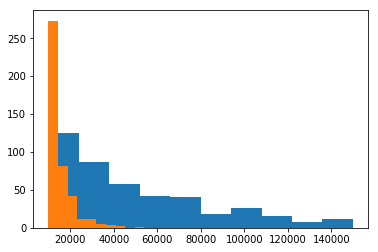

In [13]:
plt.hist(pdf_cp4.where(pdf_cp4.tmin<=np.percentile(pdf_cp4.tmin,10)).area*4.4**2)  # stronger
plt.hist(pdf_cp4.where(pdf_cp4.tmin>=np.percentile(pdf_cp4.tmin,90)).area*4.4**2)  # weaker

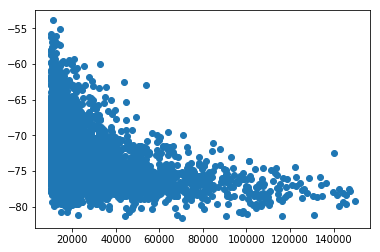

In [14]:
plt.scatter(pdf_cp4.area*(4.4**2), pdf_cp4.tmin)  # storm area und minT

In [15]:
# get era box from GRIDSAT storm centre point
def get_ERA(era, indic, clim):
    
    ano = None
    out_ds = None
    out_clim = None
    out_strong = None
    out_weak = None
    cnt = None
    cnt_strong = None
    cnt_weak = None
  
    for ids, date in enumerate(indic.date):
        
        print(date)

        getera =np.where((era['time.day']==(indic['date'])[ids].day) & (era['time.month']==indic.month[ids]) & (era['time.year']==indic.year[ids]))
        #ipdb.set_trace()
        getclim = np.where((clim['time.month']==indic.month[ids]) & (clim['time.year']==indic.year[ids]))
        try:
            era_day = era.isel(time=int(getera[0]))
            
        except TypeError:
            print('Era missing')
            continue
            
        clim_day = clim.isel(time=int(getclim[0]))
            
        tmean = indic.tmin[ids]
      
        elat = indic.clat[ids]
        elon = indic.clon[ids]
        
        print(elat,elon)
        
        point = era_day.sel(latitude=elat, longitude=elon, method='nearest')
        plat = point['latitude'].values
        plon = point['longitude'].values

        xpos = np.where(era_day['longitude'].values == plon)
        xpos = int(xpos[0])
        ypos = np.where(era_day['latitude'].values == plat)
        ypos = int(ypos[0])
        
        point = clim_day.sel(latitude=elat, longitude=elon, method='nearest')
        plat = point['latitude'].values
        plon = point['longitude'].values
        
        cxpos = np.where(clim_day['longitude'].values == plon)
        cxpos = int(cxpos[0])
        cypos = np.where(clim_day['latitude'].values == plat)
        cypos = int(cypos[0])
        
        print(ypos,xpos)

        dist=5 # ca 200km i.e. 45 *4.4km
        
        ds_box = era_day.apply(uda.cut_box, xpos=xpos, ypos=ypos, dist=dist)           
        ds_clim = clim_day.apply(uda.cut_box, xpos=cxpos, ypos=cypos, dist=dist)
        
#         f = plt.figure()
#         plt.pcolormesh(ds_box['t'])

        names = list(ds_box.data_vars)
    
#         if np.sum(np.isnan(ds_box['t'].values)!=0):
#             ipdb.set_trace()
    
#         if (ypos, xpos) == (5,20):
#             ipdb.set_trace()
       
        if cnt is None:
            cnt = np.zeros_like(ds_box[names[0]].values)
            cnt[np.isfinite(ds_box[names[0]].values)] = 1
        else:
            cnt[np.isfinite(ds_box[names[0]].values)] += 1 
            
        if tmean >= np.percentile(indic.tmean, 90):
            if cnt_weak is None:
                cnt_weak = np.zeros_like(ds_box[names[0]].values)
                cnt_weak[np.isfinite(ds_box[names[0]].values)] = 1
            else:
                
                cnt_weak[np.isfinite(ds_box[names[0]].values)] += 1 

        if tmean <= np.percentile(indic.tmean, 10):
            if cnt_strong is None:
                cnt_strong = np.zeros_like(ds_box[names[0]].values)
                cnt_strong[np.isfinite(ds_box[names[0]].values)] = 1
            else:
                cnt_strong[np.isfinite(ds_box[names[0]].values)] += 1 
                
            
        for d in ds_box.data_vars:
            ds_box[d].values[np.isnan(ds_box[d].values)]=0
        
        for d in ds_clim.data_vars:
             ds_clim[d].values[np.isnan(ds_clim[d].values)]=0
        
            
        if out_ds is None:      
            out_ds = ds_box.copy(deep=True)
        else:
            out_ds += ds_box

        if out_clim is None:      
            out_clim = ds_clim.copy(deep=True)
        else:
            out_clim += ds_clim
            
        if tmean <= np.percentile(indic.tmean, 10):           
            if out_strong is None:
                out_strong = ds_box.copy(deep=True)
            else:
                out_strong += ds_box
            
        if tmean >= np.percentile(indic.tmean, 90):
            
            if out_weak is None:
                out_weak = ds_box.copy(deep=True)
            else:
                #ipdb.set_trace()
                out_weak += ds_box
            
        
    return out_ds, out_clim, cnt, out_weak, out_strong, cnt_weak, cnt_strong

In [16]:
# def get_CP4(cp_dir, out_dir, ancils_dir, vars, datestring, box, tthresh, indic):

#     keys = vars.keys()

#     if 'lw_out_PBLtop' not in keys:
#         print('please provide ORL first in dictionary')
#         return
    
#     indic_day = indic.where(indic.date == datestring).dropna()

#     #load seamask
#     landsea_path = glob.glob(ancils_dir+os.sep+'landseamask*.nc')[0]
#     landsea = xr.open_dataset(landsea_path, decode_times=False)
#     ls = landsea['lsm']

#     ls.rlon.values = ls.rlon.values-360
#     ls_arr = ls.sel(rlon=slice(box[0], box[1]), rlat=slice(box[2], box[3]))
#     pos = np.where(ls_arr[0, 0, :, :] == 0)
#     lons, lats = np.meshgrid(ls_arr.rlon.values, ls_arr.rlat.values)
#     goodinds = 0

#     #create empty dataset
#     ds = xr.Dataset()
#     # create empty

#     #loop through every var
#     for v in keys:

#         h = (vars[v])[1]
#         pl = (vars[v])[0]
#         derived = False
#         if (v == 'shear') | (v == 'u_mid') | (v == 'u_srfc'):
#             derived = v
#             v = 'u_pl'


#         filepath = cp_dir+os.sep+str(v)+os.sep+'*'+str(int(indic_day.year[0]))+ str(int(indic_day.month[0])).zfill(2)+'*.nc'

#         arr = xr.open_mfdataset(filepath, autoclose=True)

#         dar = arr[v].sel(longitude=slice(box[0],box[1]), latitude=slice(box[2],box[3]))
        
#         pdt = pd.to_datetime(datestring)
#         pdt = pdt.replace(hour=h)
#         dar = dar.sel(time=pdt, method='nearest')
      
#         if int(dar['time.hour'])!=h:
#             print('Wrong hour')
#             return

#         if 'pressure' in dar.coords:
#             dar.values[dar.values==0] = np.nan # potential missing value maskout
#             if len(pl) > 1:
#                 shear = dar.sel(pressure=pl[0]).values - dar.sel(pressure=pl[1]).values
#                 dar = dar.sum(dim='pressure').squeeze()
#                 dar.values = shear
#                 if derived:
#                     v = derived

#             else:
#                 dar = dar.sel(pressure=pl[0]).squeeze()
#             if derived:
#                 v = derived

#         # regrid to common grid (unstagger wind, bring to landsea mask grid)
#         regrid = u_int.griddata_int(dar.values, dar.longitude, dar.latitude, ls_arr.rlon, ls_arr.rlat)
#         da = xr.DataArray(regrid,
#                           coords={'time': dar.time, 'latitude': ls_arr.rlat.values,
#                                   'longitude': ls_arr.rlon.values, },
#                           dims=['latitude', 'longitude'])


#         da.attrs = dar.attrs
#         da.values[pos[0], pos[1]] = np.nan  # mask sea

#         if v == 'lw_out_PBLtop':

#             da.values = u_met.olr_to_bt(da.values)
#             da.values[da.values >= tthresh] = 0  # T threshold maskout
#             da.values[np.isnan(da.values)] = 0 # set ocean nans to 0

#             try:
#                 date = da.time.values[0]
#             except IndexError:
#                 date = da.time.values

#         if (v == 'lsRain') | (v == 'totRain'):
#             da.values = da.values*3600  # rain to mm/h
#             da.attrs['units'] = 'mm h-1'

#         ds[v] = da

#         print('Saved ', v)

#     for index, storm in indic_day.iterrows():

#         elat = storm.clat
#         elon = storm.clon

#         dbox = ds.copy(deep=True)

#         point = dbox.sel(latitude=elat, longitude=elon, method='nearest')
#         plat = point['latitude'].values
#         plon = point['longitude'].values

#         xpos = np.where(dbox['longitude'].values == plon)
#         xpos = int(xpos[0])
#         ypos = np.where(dbox['latitude'].values == plat)
#         ypos = int(ypos[0])

#         dist=91 # ca 400km i.e. 91 *4.4km
        
#         ds_box = dbox.apply(uda.cut_box, xpos=xpos, ypos=ypos, dist=dist)           
 
#         savefile = out_dir + os.sep + str(storm.name) + '.nc'
#         try:
#             os.remove(savefile)
#         except OSError:
#             pass
        
#         for s in storm.keys():
#             #ipdb.set_trace()
#             if s == 'date':
#                 continue
#             ds_box.attrs[s] = storm[s]
        
#         ds_box.to_netcdf(path=savefile, mode='w')
#         print('Saved ' + savefile)


#         print('Saved MCS no.'+str(storm.name)+ ' as netcdf.')



# ### Inputs CP25

# data_path = cnst.network_data + 'data/CP4/CLOVER/CP4hist'  # CP4 data directory
# ancils_path = cnst.network_data + 'data/CP4/ANCILS' # directory with seamask file inside
# out_path = cnst.network_data + 'data/CP4/CLOVER/COMP4_-50_5000km2'  # out directory to save MCS files
# sbox = [-11, 11, 4.5, 8.5]  # W- E , S - N geographical storm box
# datestring = '19990401'  # set this to date of file

# years = np.array(np.arange(1998,2007), dtype=str)
# months = np.array([ '03', '04', '05', '09', '10', '11'])
# days = np.array(np.arange(1,32), dtype=str)

# tthresh = -50 # chosen temperature threshold, e.g. -50, -60, -70

# vars = OrderedDict()   # dictionary which contains info on pressure level and hour extraction for wanted variables
# vars['lw_out_PBLtop'] = ([], 18)
# vars['lsRain'] =  ([], 18)   # pressure levels, hour # totRain for CP25, lsRain for CP
# vars['shear'] = ([650, 925], 12) # should use 925 later
# vars['u_mid'] = ([650], 12)
# vars['u_srfc'] = ([925], 12)
# vars['q_pl'] = ([925], 12)  # 925, 650 available
# datelist = []
# # for y,m,d in itertools.product(years, months, days):
# #     datelist.append(y+m+str(d).zfill(2))
# # files = glob.glob(data_path+os.sep+'lw_out_PBLtop'+os.sep+'*.nc')

# #dummy = xr.open_mfdataset(data_path+os.sep+'lw_out_PBLtop'+os.sep+'*.nc', autoclose=True)

# time = np.unique(pdf_cp4.date)

# for d in time:
#     get_CP4(data_path, out_path, ancils_path, vars, d, sbox, tthresh, pdf_cp4)

In [17]:
def run_cp4_composite(indic):
    path = cnst.network_data + 'data/CP4/CLOVER/COMP4_-50_5000km2'
    perc10 = np.percentile(indic.tmean, 10)
    perc90 = np.percentile(indic.tmean, 90)
    
    files = glob.glob(path + os.sep + '*.nc')
    
    out_strong = None
    cnt_strong = None 
    out_weak = None
    cnt_weak = None
    
    for f in files:
        ds_box = xr.open_dataset(f)


        names = list(ds_box.data_vars)
         
        if ds_box.tmean >= np.percentile(indic.tmean, 90):
                if cnt_weak is None:
                    cnt_weak = np.zeros_like(ds_box[names[0]].values)
                    cnt_weak[np.isfinite(ds_box[names[0]].values)] = 1
                else:

                    cnt_weak[np.isfinite(ds_box[names[0]].values)] += 1 

        if ds_box.tmean <= np.percentile(indic.tmean, 10):
            if cnt_strong is None:
                cnt_strong = np.zeros_like(ds_box[names[0]].values)
                cnt_strong[np.isfinite(ds_box[names[0]].values)] = 1
            else:
                cnt_strong[np.isfinite(ds_box[names[0]].values)] += 1 


        for d in ds_box.data_vars:
            ds_box[d].values[np.isnan(ds_box[d].values)]=0

        if ds_box.tmean <= np.percentile(indic.tmean, 10):           
            if out_strong is None:
                out_strong = ds_box.copy(deep=True)
            else:
                out_strong += ds_box
            
        if ds_box.tmean >= np.percentile(indic.tmean, 90):
            
            if out_weak is None:
                out_weak = ds_box.copy(deep=True)
            else:
                out_weak += ds_box

    return out_strong, cnt_strong, out_weak, cnt_weak

In [18]:
cp4_strong, cp4_scnt, cp4_weak, cp4_wcnt = run_cp4_composite(pdf_cp4)

[Text(0, 0, '-600'),
 Text(0, 0, '-400'),
 Text(0, 0, '-200'),
 Text(0, 0, '0'),
 Text(0, 0, '200'),
 Text(0, 0, '400'),
 Text(0, 0, '600')]

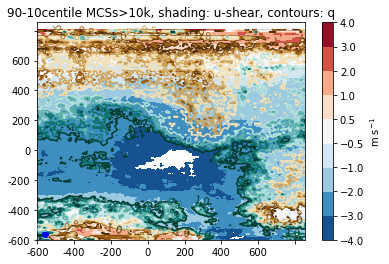

In [85]:
f = plt.figure()
ax = f.add_subplot(111)
plt.contourf((cp4_strong['u_mid'].values/cp4_scnt)-(cp4_weak['u_mid'].values/cp4_wcnt), cmap='RdBu_r', levels=[-4,-3,-2,-1,-0.5,0.5,1,2,3,4])
cbar = plt.colorbar()
cbar.set_label( 'm s$^{-1}$')
plt.title('90-10centile MCSs>10k, shading: u-shear, contours: q')
cs = plt.contour(((cp4_strong['q_pl'].values/cp4_scnt)-(cp4_weak['q_pl'].values)/cp4_wcnt)*1000, cmap='BrBG', levels=[-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1])
plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")

plt.plot(5,5,'bo')
ax.set_xticklabels([-600, -400, -200, 0, 200, 400, 600])
ax.set_yticklabels([-600, -400, -200, 0, 200, 400, 600])

In [665]:
out_ds, out_clim, cnt, out_weak, out_strong, cnt_weak, cnt_strong = get_ERA(era,pdf,clim)

1983-02-14 18:00:00
Era missing
1983-02-14 18:00:00
Era missing
1983-02-16 18:00:00
Era missing
1983-02-17 18:00:00
Era missing
1983-02-17 18:00:00
Era missing
1983-02-18 18:00:00
Era missing
1983-02-18 18:00:00
Era missing
1983-02-18 18:00:00
Era missing
1983-02-19 18:00:00
Era missing
1983-02-19 18:00:00
Era missing
1983-02-19 18:00:00
Era missing
1983-02-19 18:00:00
Era missing
1983-02-19 18:00:00
Era missing
1983-02-20 18:00:00
Era missing
1983-02-20 18:00:00
Era missing
1983-02-21 18:00:00
Era missing
1983-02-24 18:00:00
Era missing
1983-02-24 18:00:00
Era missing
1983-02-26 18:00:00
Era missing
1983-02-26 18:00:00
Era missing
1983-02-26 18:00:00
Era missing
1983-03-17 18:00:00
5.284999847412109 -7.415000915527344
3 10
1983-03-17 18:00:00
5.915000915527344 -0.4499969482421875
4 19
1983-03-18 18:00:00
5.915000915527344 -4.7550048828125
4 14
1983-03-18 18:00:00
6.790000915527344 -9.200004577636719
5 8
1983-03-18 18:00:00
5.495002746582031 -0.625
3 19
1983-03-20 18:00:00
5.5300025939

5 19
1983-05-17 18:00:00
5.530002593994141 -8.080001831054688
3 9
1983-05-18 18:00:00
6.8249969482421875 1.9650039672851562
5 23
1983-05-18 18:00:00
5.600002288818359 -2.4800033569335938
3 17
1983-05-18 18:00:00
6.755001068115234 9.840003967285156
5 33
1983-05-19 18:00:00
6.334999084472656 -9.654998779296875
4 7
1983-05-19 18:00:00
5.3899993896484375 9.314994812011719
3 32
1983-05-20 18:00:00
5.040000915527344 8.055000305175781
3 31
1983-05-20 18:00:00
6.650001525878906 -0.274993896484375
5 20
1983-05-21 18:00:00
7.700000762939453 -6.540000915527344
6 11
1983-05-21 18:00:00
7.770000457763672 -9.514999389648438
6 7
1983-05-21 18:00:00
5.460002899169922 -9.409996032714844
3 7
1983-05-21 18:00:00
6.299999237060547 9.6300048828125
4 33
1983-05-22 18:00:00
5.1100006103515625 -4.160003662109375
3 14
1983-05-22 18:00:00
6.159999847412109 -9.164993286132812
4 8
1983-05-23 18:00:00
7.944999694824219 4.94000244140625
7 27
1983-05-24 18:00:00
6.68499755859375 10.889999389648438
5 35
1983-05-25 18

3 32
1983-12-07 18:00:00
7.490001678466797 6.375
6 29
1983-12-10 18:00:00
5.530002593994141 9.455001831054688
3 33
1983-12-11 18:00:00
7.140003204345703 -0.029998779296875
6 20
1983-12-11 18:00:00
6.965000152587891 5.81500244140625
5 28
1983-12-11 18:00:00
6.159999847412109 -5.034996032714844
4 13
1983-12-12 18:00:00
5.25 -7.694999694824219
3 10
1983-12-13 18:00:00
5.635002136230469 -3.6350021362304688
4 15
1983-12-14 18:00:00
5.600002288818359 6.584999084472656
3 29
1983-12-15 18:00:00
5.005001068115234 -1.2549972534179688
3 18
1983-12-15 18:00:00
5.530002593994141 9.595001220703125
3 33
1983-12-15 18:00:00
7.034999847412109 1.404998779296875
5 22
1983-12-15 18:00:00
8.224998474121094 4.3800048828125
7 26
1983-12-17 18:00:00
5.1100006103515625 8.650001525878906
3 32
1983-12-17 18:00:00
6.055000305175781 -1.6750030517578125
4 18
1983-12-18 18:00:00
5.145000457763672 -6.19000244140625
3 12
1983-12-18 18:00:00
5.075000762939453 9.069999694824219
3 32
1983-12-18 18:00:00
5.494998931884766

1984-04-10 18:00:00
5.354999542236328 -1.8499984741210938
3 18
1984-04-10 18:00:00
5.3899993896484375 -8.779998779296875
3 8
1984-04-10 18:00:00
7.979999542236328 -9.1300048828125
7 8
1984-04-10 18:00:00
8.119998931884766 3.6800003051757812
7 25
1984-04-11 18:00:00
5.039997100830078 9.139999389648438
3 32
1984-04-11 18:00:00
5.460002899169922 -9.375
3 8
1984-04-11 18:00:00
6.125 -0.4850006103515625
4 19
1984-04-11 18:00:00
7.630001068115234 -8.7449951171875
6 8
1984-04-12 18:00:00
8.39999771118164 -8.81500244140625
7 8
1984-04-12 18:00:00
5.915000915527344 9.735000610351562
4 33
1984-04-13 18:00:00
5.670001983642578 8.370002746582031
4 31
1984-04-13 18:00:00
7.700000762939453 5.150001525878906
6 27
1984-04-13 18:00:00
5.354999542236328 -9.479995727539062
3 7
1984-04-13 18:00:00
7.034999847412109 -0.37999725341796875
5 19
1984-04-14 18:00:00
5.0749969482421875 5.6049957275390625
3 27
1984-04-15 18:00:00
7.524997711181641 5.430000305175781
6 27
1984-04-16 18:00:00
5.144996643066406 -7.83

7.1399993896484375 0.00499725341796875
6 20
1984-10-29 18:00:00
5.145000457763672 -1.3949966430664062
3 18
1984-10-31 18:00:00
5.459999084472656 -0.975006103515625
3 19
1984-11-04 18:00:00
5.319999694824219 -7.4499969482421875
3 10
1984-11-05 18:00:00
5.319999694824219 4.519996643066406
3 26
1984-11-05 18:00:00
5.950000762939453 -0.9749984741210938
4 19
1984-11-06 18:00:00
8.364997863769531 -2.5849990844726562
7 17
1984-11-06 18:00:00
5.1100006103515625 -8.290000915527344
3 9
1984-11-07 18:00:00
8.119998931884766 -9.025001525878906
7 8
1984-11-07 18:00:00
5.740001678466797 -9.444999694824219
4 7
1984-11-08 18:00:00
8.049999237060547 -8.7449951171875
7 8
1984-11-09 18:00:00
5.530002593994141 -3.1800003051757812
3 16
1984-11-09 18:00:00
7.700000762939453 -7.099998474121094
6 11
1984-11-11 18:00:00
7.875 -7.589996337890625
7 10
1984-11-11 18:00:00
5.80999755859375 7.775001525878906
4 30
1984-11-12 18:00:00
7.31500244140625 2.5250015258789062
6 23
1984-11-12 18:00:00
5.460002899169922 -9.4

1985-04-04 18:00:00
7.350002288818359 -2.1299972534179688
6 17
1985-04-04 18:00:00
7.805000305175781 1.7549972534179688
6 22
1985-04-04 18:00:00
7.840000152587891 -6.400001525878906
6 11
1985-04-05 18:00:00
5.25 -6.715003967285156
3 11
1985-04-05 18:00:00
6.5800018310546875 4.660003662109375
5 26
1985-04-05 18:00:00
7.454998016357422 0.80999755859375
6 21
1985-04-05 18:00:00
6.719997406005859 10.43499755859375
5 34
1985-04-06 18:00:00
5.355003356933594 -8.955001831054688
3 8
1985-04-06 18:00:00
5.075000762939453 8.265007019042969
3 31
1985-04-06 18:00:00
6.895000457763672 2.4550018310546875
5 23
1985-04-06 18:00:00
7.979999542236328 -2.1649932861328125
7 17
1985-04-06 18:00:00
8.294998168945312 -8.814994812011719
7 8
1985-04-07 18:00:00
5.599998474121094 -8.989997863769531
3 8
1985-04-09 18:00:00
8.119998931884766 -1.6750030517578125
7 18
1985-04-09 18:00:00
8.400001525878906 -8.639999389648438
7 8
1985-04-10 18:00:00
5.040000915527344 -3.9850006103515625
3 15
1985-04-10 18:00:00
5.180

1985-10-14 18:00:00
6.685001373291016 5.9550018310546875
5 28
1985-10-14 18:00:00
7.385002136230469 -8.779998779296875
6 8
1985-10-15 18:00:00
6.790000915527344 -1.9199981689453125
5 17
1985-10-15 18:00:00
7.245002746582031 10.19000244140625
6 34
1985-10-16 18:00:00
7.7350006103515625 -0.660003662109375
6 19
1985-10-16 18:00:00
8.084999084472656 -3.7050018310546875
7 15
1985-10-16 18:00:00
6.055000305175781 -6.6450042724609375
4 11
1985-10-17 18:00:00
5.740001678466797 -2.6200027465820312
4 17
1985-10-18 18:00:00
5.600002288818359 -2.1300048828125
3 17
1985-10-18 18:00:00
6.194999694824219 9.560005187988281
4 33
1985-10-18 18:00:00
7.909999847412109 -9.550003051757812
7 7
1985-10-19 18:00:00
6.334999084472656 9.349998474121094
4 32
1985-10-19 18:00:00
6.789997100830078 5.290000915527344
5 27
1985-10-19 18:00:00
8.119998931884766 -9.654998779296875
7 7
1985-10-20 18:00:00
5.495002746582031 8.7550048828125
3 32
1985-10-20 18:00:00
6.439998626708984 4.94000244140625
5 27
1985-10-21 18:00:

1986-02-20 18:00:00
6.020000457763672 -1.42999267578125
4 18
1986-02-20 18:00:00
6.474998474121094 -5.875
5 12
1986-02-20 18:00:00
8.119998931884766 -8.324996948242188
7 9
1986-02-21 18:00:00
5.215000152587891 -7.4850006103515625
3 10
1986-02-22 18:00:00
5.0749969482421875 6.8300018310546875
3 29
1986-02-22 18:00:00
7.4550018310546875 4.94000244140625
6 27
1986-02-26 18:00:00
6.160003662109375 6.025001525878906
4 28
1986-02-26 18:00:00
5.915000915527344 9.700004577636719
4 33
1986-02-26 18:00:00
7.875 0.9850006103515625
7 21
1986-02-26 18:00:00
7.630001068115234 -6.959999084472656
6 11
1986-02-26 18:00:00
7.840000152587891 -2.5850067138671875
6 17
1986-02-26 18:00:00
8.189998626708984 3.8899993896484375
7 25
1986-02-27 18:00:00
5.530002593994141 -5.840003967285156
3 12
1986-02-27 18:00:00
7.209999084472656 0.07500457763671875
6 20
1986-02-27 18:00:00
7.1750030517578125 -7.555000305175781
6 10
1986-02-28 18:00:00
6.404998779296875 1.3000030517578125
5 22
1986-02-28 18:00:00
5.1100006103

1986-05-07 18:00:00
5.845001220703125 -1.1149978637695312
4 19
1986-05-07 18:00:00
6.649997711181641 10.889999389648438
5 35
1986-05-07 18:00:00
7.31500244140625 0.25
6 20
1986-05-07 18:00:00
5.145000457763672 8.825004577636719
3 32
1986-05-08 18:00:00
5.039997100830078 8.650001525878906
3 32
1986-05-08 18:00:00
5.1100006103515625 -7.344993591308594
3 10
1986-05-08 18:00:00
8.329998016357422 -8.675003051757812
7 8
1986-05-09 18:00:00
5.075000762939453 -7.905006408691406
3 9
1986-05-09 18:00:00
5.775001525878906 -5.0
4 13
1986-05-09 18:00:00
6.369998931884766 -0.8700027465820312
4 19
1986-05-09 18:00:00
7.875 1.3700027465820312
7 22
1986-05-09 18:00:00
7.490001678466797 -7.519996643066406
6 10
1986-05-10 18:00:00
5.9499969482421875 -6.75
4 11
1986-05-11 18:00:00
5.880001068115234 -0.8349990844726562
4 19
1986-05-12 18:00:00
5.950000762939453 -4.3350067138671875
4 14
1986-05-12 18:00:00
5.25 -7.2050018310546875
3 10
1986-05-13 18:00:00
7.700000762939453 -8.534996032714844
6 9
1986-05-13 

3 18
1987-01-19 18:00:00
7.069999694824219 1.4749984741210938
5 22
1987-01-20 18:00:00
8.189998626708984 -7.975006103515625
7 9
1987-02-02 18:00:00
5.845001220703125 6.864997863769531
4 29
1987-02-03 18:00:00
7.630001068115234 5.3600006103515625
6 27
1987-02-05 18:00:00
5.460002899169922 -2.05999755859375
3 17
1987-02-12 18:00:00
6.020000457763672 0.8800048828125
4 21
1987-02-12 18:00:00
6.930000305175781 3.75
5 25
1987-02-13 18:00:00
5.284999847412109 -5.1049957275390625
3 13
1987-02-13 18:00:00
6.720001220703125 -5.069999694824219
5 13
1987-02-13 18:00:00
7.385002136230469 1.9650039672851562
6 23
1987-02-13 18:00:00
8.294998168945312 5.534996032714844
7 27
1987-02-14 18:00:00
5.635002136230469 -0.06499481201171875
4 20
1987-02-14 18:00:00
5.7050018310546875 -2.095001220703125
4 17
1987-02-14 18:00:00
6.615001678466797 10.050003051757812
5 33
1987-02-14 18:00:00
5.459999084472656 3.7150039672851562
3 25
1987-02-15 18:00:00
5.56500244140625 -7.4499969482421875
3 10
1987-02-15 18:00:00


1987-04-18 18:00:00
6.930000305175781 -1.9900054931640625
5 17
1987-04-18 18:00:00
7.31500244140625 3.1200027465820312
6 24
1987-04-18 18:00:00
7.875 -7.555000305175781
7 10
1987-04-19 18:00:00
6.930000305175781 -1.1149978637695312
5 19
1987-04-19 18:00:00
5.775001525878906 -5.6999969482421875
4 12
1987-04-19 18:00:00
6.755001068115234 -6.19000244140625
5 12
1987-04-19 18:00:00
7.4550018310546875 4.590003967285156
6 26
1987-04-19 18:00:00
8.014999389648438 -7.625
7 10
1987-04-19 18:00:00
5.56500244140625 9.034996032714844
3 32
1987-04-20 18:00:00
5.775001525878906 -0.41500091552734375
4 19
1987-04-22 18:00:00
5.284999847412109 -6.8549957275390625
3 11
1987-04-23 18:00:00
6.090000152587891 -5.489997863769531
4 13
1987-04-24 18:00:00
5.915000915527344 -5.349998474121094
4 13
1987-04-25 18:00:00
5.880001068115234 -0.274993896484375
4 20
1987-04-26 18:00:00
6.965000152587891 -4.2649993896484375
5 14
1987-04-26 18:00:00
7.944999694824219 -8.745002746582031
7 8
1987-04-26 18:00:00
5.39000320

1987-10-18 18:00:00
6.930000305175781 -1.535003662109375
5 18
1987-10-19 18:00:00
5.25 9.0
3 32
1987-10-19 18:00:00
5.354999542236328 -2.3050003051757812
3 17
1987-10-19 18:00:00
5.810001373291016 -9.270004272460938
4 8
1987-10-19 18:00:00
7.0 3.4000015258789062
5 25
1987-10-20 18:00:00
6.090000152587891 -3.5999984741210938
4 15
1987-10-20 18:00:00
6.895000457763672 3.399993896484375
5 25
1987-10-20 18:00:00
8.049999237060547 0.5999984741210938
7 21
1987-10-20 18:00:00
8.014999389648438 5.185005187988281
7 27
1987-10-20 18:00:00
5.075000762939453 9.770004272460938
3 33
1987-10-21 18:00:00
5.599998474121094 -5.31500244140625
3 13
1987-10-21 18:00:00
6.2649993896484375 -0.029998779296875
4 20
1987-10-21 18:00:00
6.649997711181641 -7.555000305175781
5 10
1987-10-21 18:00:00
7.4550018310546875 1.3000030517578125
6 22
1987-10-21 18:00:00
8.014999389648438 -2.4800033569335938
7 17
1987-10-21 18:00:00
8.224998474121094 -5.55999755859375
7 13
1987-10-22 18:00:00
5.634998321533203 -5.7700042724

1988-03-02 18:00:00
5.950000762939453 9.770004272460938
4 33
1988-03-02 18:00:00
6.334999084472656 5.989997863769531
4 28
1988-03-02 18:00:00
7.210002899169922 10.715003967285156
6 34
1988-03-02 18:00:00
7.4550018310546875 3.75
6 25
1988-03-03 18:00:00
6.615001678466797 -4.439994812011719
5 14
1988-03-03 18:00:00
7.245002746582031 3.7150039672851562
6 25
1988-03-04 18:00:00
7.350002288818359 3.43499755859375
6 25
1988-03-05 18:00:00
5.634998321533203 8.650001525878906
4 32
1988-03-05 18:00:00
6.789997100830078 5.430000305175781
5 27
1988-03-05 18:00:00
6.719997406005859 10.470001220703125
5 34
1988-03-05 18:00:00
7.840000152587891 0.32000732421875
6 20
1988-03-06 18:00:00
5.56500244140625 -4.089996337890625
3 15
1988-03-06 18:00:00
6.5449981689453125 9.279998779296875
5 32
1988-03-07 18:00:00
7.070003509521484 -2.05999755859375
5 17
1988-03-09 18:00:00
5.040000915527344 5.814994812011719
3 28
1988-03-09 18:00:00
6.090000152587891 8.790000915527344
4 32
1988-03-09 18:00:00
7.73500061035

6.5449981689453125 -1.7099990844726562
5 18
1988-04-29 18:00:00
5.320003509521484 5.849998474121094
3 28
1988-04-29 18:00:00
6.299999237060547 10.155006408691406
4 34
1988-04-30 18:00:00
5.180000305175781 -8.709999084472656
3 8
1988-04-30 18:00:00
6.125 9.979995727539062
4 33
1988-04-30 18:00:00
5.284999847412109 -6.8899993896484375
3 11
1988-04-30 18:00:00
6.755001068115234 2.9800033569335938
5 24
1988-05-01 18:00:00
6.510002136230469 4.8350067138671875
5 26
1988-05-02 18:00:00
6.720001220703125 2.875
5 24
1988-05-02 18:00:00
5.390003204345703 -6.504997253417969
3 11
1988-05-03 18:00:00
8.224998474121094 -8.884994506835938
7 8
1988-05-04 18:00:00
5.005001068115234 8.68499755859375
3 32
1988-05-04 18:00:00
7.174999237060547 10.680000305175781
6 34
1988-05-07 18:00:00
5.950000762939453 9.839996337890625
4 33
1988-05-08 18:00:00
5.704998016357422 5.6399993896484375
4 28
1988-05-08 18:00:00
7.000003814697266 7.704994201660156
5 30
1988-05-09 18:00:00
5.635002136230469 -1.5
4 18
1988-05-09

1988-11-01 18:00:00
6.2649993896484375 0.845001220703125
4 21
1988-11-01 18:00:00
6.510002136230469 2.8400039672851562
5 24
1988-11-02 18:00:00
6.194999694824219 -1.1500015258789062
4 18
1988-11-02 18:00:00
7.069999694824219 1.2300033569335938
5 22
1988-11-03 18:00:00
6.2649993896484375 -0.8699951171875
4 19
1988-11-04 18:00:00
5.390003204345703 -6.924995422363281
3 11
1988-11-09 18:00:00
5.145000457763672 8.825004577636719
3 32
1988-11-10 18:00:00
5.3899993896484375 -0.6949996948242188
3 19
1988-11-10 18:00:00
6.159999847412109 0.7400054931640625
4 21
1988-11-11 18:00:00
5.530002593994141 8.615005493164062
3 31
1988-11-11 18:00:00
5.424999237060547 -4.8249969482421875
3 14
1988-11-12 18:00:00
5.145000457763672 -6.575004577636719
3 11
1988-11-12 18:00:00
5.530002593994141 -1.5699996948242188
3 18
1988-11-12 18:00:00
5.459999084472656 -4.3699951171875
3 14
1988-11-13 18:00:00
5.180000305175781 6.129997253417969
3 28
1988-11-13 18:00:00
5.459999084472656 -1.5699996948242188
3 18
1988-11-

1989-03-21 18:00:00
7.034999847412109 1.5100021362304688
5 22
1989-03-21 18:00:00
7.944999694824219 5.745002746582031
7 28
1989-03-21 18:00:00
5.495002746582031 -9.129997253417969
3 8
1989-03-22 18:00:00
6.8600006103515625 5.254997253417969
5 27
1989-03-22 18:00:00
6.439998626708984 10.75
5 34
1989-03-22 18:00:00
5.460002899169922 7.1100006103515625
3 29
1989-03-23 18:00:00
5.494998931884766 -7.660003662109375
3 10
1989-03-23 18:00:00
5.530002593994141 9.209999084472656
3 32
1989-03-23 18:00:00
5.775001525878906 10.9949951171875
4 35
1989-03-23 18:00:00
6.545001983642578 1.6150054931640625
5 22
1989-03-23 18:00:00
7.350002288818359 7.25
6 30
1989-03-23 18:00:00
8.014999389648438 6.025001525878906
7 28
1989-03-24 18:00:00
5.704998016357422 9.280006408691406
4 32
1989-03-25 18:00:00
6.335002899169922 9.245002746582031
4 32
1989-03-25 18:00:00
5.635002136230469 -2.8300018310546875
4 16
1989-03-25 18:00:00
6.334999084472656 5.430000305175781
4 27
1989-03-25 18:00:00
6.8600006103515625 10.9

1989-05-23 18:00:00
5.284999847412109 -1.9899978637695312
3 17
1989-05-23 18:00:00
5.319999694824219 -4.159996032714844
3 14
1989-05-23 18:00:00
5.7050018310546875 -8.639999389648438
4 8
1989-05-24 18:00:00
5.600002288818359 -8.919998168945312
3 8
1989-05-24 18:00:00
6.545001983642578 8.404998779296875
5 31
1989-05-25 18:00:00
5.215000152587891 5.3249969482421875
3 27
1989-05-25 18:00:00
5.775001525878906 -3.4249954223632812
4 15
1989-05-25 18:00:00
8.364997863769531 1.6850051879882812
7 22
1989-05-26 18:00:00
7.560001373291016 -7.4850006103515625
6 10
1989-05-26 18:00:00
7.630001068115234 -1.0100021362304688
6 19
1989-05-26 18:00:00
8.329998016357422 -9.970001220703125
7 7
1989-05-27 18:00:00
6.930000305175781 10.715003967285156
5 34
1989-05-27 18:00:00
5.56500244140625 9.139999389648438
3 32
1989-05-27 18:00:00
5.670001983642578 -7.099998474121094
4 11
1989-05-28 18:00:00
5.040000915527344 -7.590003967285156
3 10
1989-05-28 18:00:00
5.075000762939453 9.139999389648438
3 32
1989-05-28

1989-12-14 18:00:00
7.420001983642578 1.5100021362304688
6 22
1989-12-27 18:00:00
5.1100006103515625 -9.830001831054688
3 7
1989-12-28 18:00:00
5.775001525878906 -0.8000030517578125
4 19
1989-12-29 18:00:00
6.299999237060547 -2.6199951171875
4 17
1989-12-30 18:00:00
5.915000915527344 -7.7649993896484375
4 10
1989-12-30 18:00:00
8.014999389648438 -8.254997253417969
7 9
1990-01-09 18:00:00
5.460002899169922 -8.360000610351562
3 9
1990-01-09 18:00:00
7.035003662109375 -8.569999694824219
5 9
1990-01-19 18:00:00
6.229999542236328 0.49500274658203125
4 21
1990-01-19 18:00:00
7.560001373291016 -0.23999786376953125
6 20
1990-01-20 18:00:00
5.460002899169922 -5.069999694824219
3 13
1990-01-20 18:00:00
5.635002136230469 -2.095001220703125
4 17
1990-01-20 18:00:00
7.349998474121094 1.5100021362304688
6 22
1990-01-21 18:00:00
5.670001983642578 -3.214996337890625
4 16
1990-01-21 18:00:00
6.020000457763672 -5.209999084472656
4 13
1990-01-21 18:00:00
6.685001373291016 6.410003662109375
5 29
1990-01-2

1990-05-03 18:00:00
6.719997406005859 4.94000244140625
5 27
1990-05-04 18:00:00
5.215000152587891 9.0
3 32
1990-05-04 18:00:00
8.189998626708984 -8.954994201660156
7 8
1990-05-05 18:00:00
6.614997863769531 4.4499969482421875
5 26
1990-05-05 18:00:00
7.034999847412109 2.4899978637695312
5 23
1990-05-05 18:00:00
5.390003204345703 -7.4149932861328125
3 10
1990-05-06 18:00:00
5.1100006103515625 -7.904998779296875
3 9
1990-05-06 18:00:00
8.295001983642578 -4.090003967285156
7 15
1990-05-07 18:00:00
5.075000762939453 -9.165000915527344
3 8
1990-05-07 18:00:00
5.459999084472656 8.404998779296875
3 31
1990-05-08 18:00:00
5.040000915527344 8.335006713867188
3 31
1990-05-09 18:00:00
6.055000305175781 8.964996337890625
4 32
1990-05-09 18:00:00
5.880001068115234 -4.650001525878906
4 14
1990-05-10 18:00:00
8.400001525878906 4.625
7 26
1990-05-11 18:00:00
7.875 -8.220001220703125
7 9
1990-05-11 18:00:00
5.25 -8.464996337890625
3 9
1990-05-12 18:00:00
7.314998626708984 10.644996643066406
6 34
1990-05

4 11
1990-11-13 18:00:00
7.525001525878906 1.3700027465820312
6 22
1990-11-13 18:00:00
7.595001220703125 3.6100006103515625
6 25
1990-11-14 18:00:00
7.770000457763672 -8.745002746582031
6 8
1990-11-14 18:00:00
7.4550018310546875 -1.9899978637695312
6 17
1990-11-14 18:00:00
6.055000305175781 9.175003051757812
4 32
1990-11-15 18:00:00
8.329998016357422 -7.7299957275390625
7 10
1990-11-15 18:00:00
5.845001220703125 8.860000610351562
4 32
1990-11-15 18:00:00
7.980003356933594 0.6699981689453125
7 21
1990-11-15 18:00:00
7.560001373291016 -3.25
6 16
1990-11-15 18:00:00
7.245002746582031 2.6299972534179688
6 24
1990-11-16 18:00:00
8.329998016357422 0.25
7 20
1990-11-17 18:00:00
5.530002593994141 -7.5200042724609375
3 10
1990-11-17 18:00:00
5.880001068115234 -1.220001220703125
4 18
1990-11-18 18:00:00
5.845001220703125 -6.8899993896484375
4 11
1990-11-18 18:00:00
5.915000915527344 -1.0100021362304688
4 19
1990-11-18 18:00:00
7.770000457763672 -2.024993896484375
6 17
1990-11-18 18:00:00
5.18000

1991-02-27 18:00:00
7.314998626708984 0.7400054931640625
6 21
1991-02-27 18:00:00
7.4199981689453125 6.095001220703125
6 28
1991-02-27 18:00:00
8.364997863769531 -1.9199981689453125
7 17
1991-02-27 18:00:00
5.600002288818359 -8.290000915527344
3 9
1991-02-28 18:00:00
6.895000457763672 -3.7399978637695312
5 15
1991-03-01 18:00:00
6.020000457763672 7.1100006103515625
4 29
1991-03-01 18:00:00
6.404998779296875 10.120002746582031
5 33
1991-03-01 18:00:00
6.649997711181641 -5.349998474121094
5 13
1991-03-01 18:00:00
7.350002288818359 -1.0800018310546875
6 19
1991-03-01 18:00:00
7.174999237060547 3.5400009155273438
6 25
1991-03-02 18:00:00
5.215000152587891 -1.8499984741210938
3 18
1991-03-03 18:00:00
5.040000915527344 -7.100006103515625
3 11
1991-03-05 18:00:00
6.439998626708984 5.605003356933594
5 27
1991-03-05 18:00:00
6.369998931884766 -0.589996337890625
4 19
1991-03-05 18:00:00
7.104999542236328 1.160003662109375
5 22
1991-03-05 18:00:00
7.595001220703125 3.7150039672851562
6 25
1991-03

4 14
1991-04-13 18:00:00
7.4199981689453125 8.824996948242188
6 32
1991-04-13 18:00:00
6.229999542236328 -0.1699981689453125
4 20
1991-04-13 18:00:00
6.895000457763672 2.4899978637695312
5 23
1991-04-14 18:00:00
5.529998779296875 -8.639999389648438
3 8
1991-04-14 18:00:00
7.350002288818359 -7.1699981689453125
6 10
1991-04-15 18:00:00
6.159999847412109 10.575004577636719
4 34
1991-04-15 18:00:00
5.284999847412109 8.650001525878906
3 32
1991-04-15 18:00:00
5.424999237060547 -3.0749969482421875
3 16
1991-04-16 18:00:00
5.6699981689453125 9.245002746582031
4 32
1991-04-17 18:00:00
6.650001525878906 9.595001220703125
5 33
1991-04-18 18:00:00
5.530002593994141 -7.6949920654296875
3 10
1991-04-18 18:00:00
5.495002746582031 9.069999694824219
3 32
1991-04-20 18:00:00
6.439998626708984 9.805000305175781
5 33
1991-04-23 18:00:00
6.299999237060547 9.55999755859375
4 33
1991-04-24 18:00:00
6.334999084472656 5.325004577636719
4 27
1991-04-25 18:00:00
5.880001068115234 -1.7450027465820312
4 18
1991-0

1991-10-21 18:00:00
5.775001525878906 8.930000305175781
4 32
1991-10-22 18:00:00
5.915000915527344 -7.239997863769531
4 10
1991-10-22 18:00:00
6.579998016357422 -3.3550033569335938
5 16
1991-10-23 18:00:00
5.0749969482421875 5.9199981689453125
3 28
1991-10-24 18:00:00
5.880001068115234 8.370002746582031
4 31
1991-10-24 18:00:00
7.7350006103515625 -8.639999389648438
6 8
1991-10-25 18:00:00
6.334999084472656 10.085006713867188
4 33
1991-10-25 18:00:00
6.369998931884766 -0.5200042724609375
4 19
1991-10-26 18:00:00
5.670001983642578 5.954994201660156
4 28
1991-10-26 18:00:00
6.755001068115234 9.805000305175781
5 33
1991-10-27 18:00:00
5.284999847412109 9.525001525878906
3 33
1991-10-27 18:00:00
6.68499755859375 10.785003662109375
5 34
1991-10-27 18:00:00
7.700000762939453 4.765007019042969
6 26
1991-10-28 18:00:00
7.210002899169922 10.925003051757812
6 35
1991-10-28 18:00:00
8.120002746582031 -1.0800018310546875
7 19
1991-10-28 18:00:00
7.4550018310546875 -9.199996948242188
6 8
1991-10-28 

4 19
1992-04-09 18:00:00
7.909999847412109 -9.339996337890625
7 8
1992-04-09 18:00:00
6.369998931884766 9.0
4 32
1992-04-10 18:00:00
7.55999755859375 5.3600006103515625
6 27
1992-04-10 18:00:00
5.319999694824219 6.549995422363281
3 29
1992-04-10 18:00:00
6.055000305175781 -2.1650009155273438
4 17
1992-04-11 18:00:00
5.215000152587891 9.875
3 33
1992-04-11 18:00:00
5.635002136230469 -4.649993896484375
4 14
1992-04-11 18:00:00
5.880001068115234 -2.05999755859375
4 17
1992-04-11 18:00:00
6.020000457763672 0.4250030517578125
4 21
1992-04-11 18:00:00
8.014999389648438 -4.964996337890625
7 13
1992-04-11 18:00:00
8.470001220703125 4.30999755859375
7 26
1992-04-11 18:00:00
5.215000152587891 -7.625
3 10
1992-04-12 18:00:00
5.915000915527344 -2.2700042724609375
4 17
1992-04-12 18:00:00
6.194999694824219 8.125
4 31
1992-04-13 18:00:00
6.68499755859375 0.5300064086914062
5 21
1992-04-13 18:00:00
7.490001678466797 -4.230003356933594
6 14
1992-04-14 18:00:00
7.525001525878906 -9.795005798339844
6 7


1992-10-08 18:00:00
5.740001678466797 5.465003967285156
4 27
1992-10-09 18:00:00
7.104999542236328 -1.464996337890625
5 18
1992-10-11 18:00:00
6.334999084472656 5.605003356933594
4 27
1992-10-11 18:00:00
6.5449981689453125 -1.535003662109375
5 18
1992-10-11 18:00:00
5.494998931884766 8.650001525878906
3 32
1992-10-12 18:00:00
5.740001678466797 8.510002136230469
4 31
1992-10-12 18:00:00
6.5449981689453125 -9.584999084472656
5 7
1992-10-12 18:00:00
6.5449981689453125 0.3899993896484375
5 21
1992-10-12 18:00:00
7.4550018310546875 7.6699981689453125
6 30
1992-10-12 18:00:00
8.014999389648438 3.9950027465820312
7 25
1992-10-13 18:00:00
5.635002136230469 8.615005493164062
4 31
1992-10-14 18:00:00
7.245002746582031 10.819999694824219
6 34
1992-10-14 18:00:00
6.194999694824219 6.69000244140625
4 29
1992-10-14 18:00:00
6.159999847412109 8.614997863769531
4 31
1992-10-15 18:00:00
7.665000915527344 4.344993591308594
6 26
1992-10-15 18:00:00
5.320003509521484 7.215003967285156
3 30
1992-10-16 18:0

5.075000762939453 5.779998779296875
3 28
1993-02-23 18:00:00
8.084999084472656 -5.524993896484375
7 13
1993-02-25 18:00:00
6.334999084472656 -1.4300003051757812
4 18
1993-02-25 18:00:00
7.630001068115234 2.875
6 24
1993-02-25 18:00:00
8.119998931884766 -7.625
7 10
1993-02-27 18:00:00
5.739997863769531 5.6750030517578125
4 28
1993-02-27 18:00:00
6.405002593994141 9.31500244140625
5 32
1993-02-27 18:00:00
6.965000152587891 10.610000610351562
5 34
1993-02-28 18:00:00
6.159999847412109 -3.1100006103515625
4 16
1993-02-28 18:00:00
7.55999755859375 -0.23999786376953125
6 20
1993-02-28 18:00:00
6.5449981689453125 9.525001525878906
5 33
1993-02-28 18:00:00
7.770000457763672 5.185005187988281
6 27
1993-02-28 18:00:00
8.330001831054688 -7.7299957275390625
7 10
1993-02-28 18:00:00
5.9850006103515625 -8.5
4 9
1993-03-01 18:00:00
5.25 10.575004577636719
3 34
1993-03-01 18:00:00
6.090000152587891 -3.3549957275390625
4 16
1993-03-01 18:00:00
6.614997863769531 -0.7999954223632812
5 19
1993-03-01 18:00

1993-04-22 18:00:00
7.944999694824219 -8.430000305175781
7 9
1993-04-22 18:00:00
8.43499755859375 -3.7049942016601562
7 15
1993-04-25 18:00:00
5.9850006103515625 -1.535003662109375
4 18
1993-04-25 18:00:00
5.635002136230469 5.430000305175781
4 27
1993-04-25 18:00:00
7.490001678466797 3.154998779296875
6 24
1993-04-26 18:00:00
6.229999542236328 6.025001525878906
4 28
1993-04-26 18:00:00
7.560001373291016 -7.1699981689453125
6 10
1993-04-26 18:00:00
5.25 -7.239997863769531
3 10
1993-04-26 18:00:00
5.109996795654297 7.529998779296875
3 30
1993-04-26 18:00:00
5.529998779296875 -2.8300018310546875
3 16
1993-04-27 18:00:00
6.334999084472656 9.875007629394531
4 33
1993-04-28 18:00:00
5.3899993896484375 -8.430000305175781
3 9
1993-04-28 18:00:00
7.104999542236328 5.709999084472656
5 28
1993-04-28 18:00:00
6.055000305175781 9.525001525878906
4 33
1993-04-28 18:00:00
6.404998779296875 -5.035003662109375
5 13
1993-04-28 18:00:00
8.365001678466797 -2.7249984741210938
7 16
1993-04-30 18:00:00
8.329

1993-10-26 18:00:00
8.119998931884766 5.569999694824219
7 27
1993-10-26 18:00:00
5.635002136230469 -3.8799972534179688
4 15
1993-10-26 18:00:00
7.105003356933594 0.35500335693359375
5 20
1993-10-27 18:00:00
8.46999740600586 -8.079994201660156
7 9
1993-10-27 18:00:00
5.1100006103515625 -7.4850006103515625
3 10
1993-10-27 18:00:00
5.845001220703125 -0.8000030517578125
4 19
1993-10-27 18:00:00
7.0 -0.06500244140625
5 20
1993-10-27 18:00:00
7.7350006103515625 4.94000244140625
6 27
1993-10-28 18:00:00
5.284999847412109 -7.904998779296875
3 9
1993-10-28 18:00:00
6.404998779296875 5.5
5 27
1993-10-28 18:00:00
7.210002899169922 4.8000030517578125
6 26
1993-10-28 18:00:00
7.244998931884766 -7.974998474121094
6 9
1993-10-28 18:00:00
5.320003509521484 -3.4600067138671875
3 15
1993-10-28 18:00:00
5.075000762939453 9.279998779296875
3 32
1993-10-29 18:00:00
5.319999694824219 8.650001525878906
3 32
1993-10-29 18:00:00
5.460002899169922 -2.69000244140625
3 16
1993-10-30 18:00:00
5.950000762939453 7.2

1994-02-28 18:00:00
6.614997863769531 1.1949996948242188
5 22
1994-03-01 18:00:00
6.755001068115234 -4.299995422363281
5 14
1994-03-02 18:00:00
5.285003662109375 9.279998779296875
3 32
1994-03-03 18:00:00
7.665000915527344 -6.3650054931640625
6 12
1994-03-03 18:00:00
7.875 5.394996643066406
7 27
1994-03-04 18:00:00
5.810001373291016 -5.7350006103515625
4 12
1994-03-04 18:00:00
6.44000244140625 10.155006408691406
5 34
1994-03-04 18:00:00
7.385002136230469 -2.2000045776367188
6 17
1994-03-06 18:00:00
5.7050018310546875 10.645004272460938
4 34
1994-03-07 18:00:00
5.494998931884766 -5.489997863769531
3 13
1994-03-08 18:00:00
6.229999542236328 -8.569999694824219
4 9
1994-03-08 18:00:00
6.2649993896484375 10.189994812011719
4 34
1994-03-08 18:00:00
8.120002746582031 -7.135002136230469
7 10
1994-03-09 18:00:00
6.439998626708984 5.5
5 27
1994-03-09 18:00:00
6.159999847412109 9.210006713867188
4 32
1994-03-09 18:00:00
7.174999237060547 -0.9749984741210938
6 19
1994-03-09 18:00:00
7.595001220703

1994-04-21 18:00:00
6.474998474121094 1.1599960327148438
5 22
1994-04-22 18:00:00
5.950000762939453 9.139999389648438
4 32
1994-04-22 18:00:00
7.1399993896484375 -0.23999786376953125
6 20
1994-04-22 18:00:00
7.069999694824219 3.9599990844726562
5 25
1994-04-22 18:00:00
7.630001068115234 -8.394996643066406
6 9
1994-04-22 18:00:00
7.805000305175781 5.18499755859375
6 27
1994-04-23 18:00:00
6.439998626708984 10.610000610351562
5 34
1994-04-23 18:00:00
7.944999694824219 3.9950027465820312
7 25
1994-04-24 18:00:00
5.7050018310546875 -1.5
4 18
1994-04-26 18:00:00
5.530002593994141 -2.6200027465820312
3 17
1994-04-26 18:00:00
6.090000152587891 -4.894996643066406
4 13
1994-04-28 18:00:00
5.880001068115234 9.595001220703125
4 33
1994-04-30 18:00:00
5.495002746582031 8.160003662109375
3 31
1994-04-30 18:00:00
5.635002136230469 -8.639999389648438
4 8
1994-05-01 18:00:00
5.319999694824219 8.544998168945312
3 31
1994-05-01 18:00:00
8.15500259399414 0.5649948120117188
7 21
1994-05-02 18:00:00
6.4749

5.7050018310546875 8.894996643066406
4 32
1994-10-15 18:00:00
7.140003204345703 -2.1299972534179688
6 17
1994-10-15 18:00:00
7.525001525878906 0.9150009155273438
6 21
1994-10-16 18:00:00
7.069999694824219 -9.760002136230469
5 7
1994-10-16 18:00:00
7.0 4.939994812011719
5 27
1994-10-17 18:00:00
6.650001525878906 10.539993286132812
5 34
1994-10-17 18:00:00
6.090000152587891 8.194999694824219
4 31
1994-10-17 18:00:00
6.229999542236328 -8.7449951171875
4 8
1994-10-18 18:00:00
6.720001220703125 -2.0250015258789062
5 17
1994-10-18 18:00:00
5.740001678466797 4.415000915527344
4 26
1994-10-18 18:00:00
6.020000457763672 8.790000915527344
4 32
1994-10-20 18:00:00
6.194999694824219 -5.875
4 12
1994-10-20 18:00:00
6.369998931884766 -0.8699951171875
4 19
1994-10-20 18:00:00
7.140003204345703 -8.674995422363281
6 8
1994-10-20 18:00:00
6.44000244140625 8.930000305175781
5 32
1994-10-21 18:00:00
6.125 -2.2000045776367188
4 17
1994-10-21 18:00:00
7.384998321533203 -0.8699951171875
6 19
1994-10-22 18:00

6.720001220703125 5.290000915527344
5 27
1995-03-10 18:00:00
7.490001678466797 0.8100051879882812
6 21
1995-03-10 18:00:00
7.700000762939453 -7.204994201660156
6 10
1995-03-11 18:00:00
5.459999084472656 10.120002746582031
3 33
1995-03-11 18:00:00
6.159999847412109 5.6049957275390625
4 27
1995-03-13 18:00:00
5.810001373291016 -6.959999084472656
4 11
1995-03-13 18:00:00
7.944999694824219 -7.415000915527344
7 10
1995-03-13 18:00:00
8.294998168945312 4.870002746582031
7 26
1995-03-14 18:00:00
7.630001068115234 -3.4250030517578125
6 15
1995-03-15 18:00:00
6.650001525878906 -6.784996032714844
5 11
1995-03-15 18:00:00
5.530002593994141 9.455001831054688
3 33
1995-03-15 18:00:00
5.424999237060547 6.095001220703125
3 28
1995-03-15 18:00:00
8.189998626708984 6.024993896484375
7 28
1995-03-17 18:00:00
6.334999084472656 -3.1800003051757812
4 16
1995-03-17 18:00:00
7.665000915527344 5.3950042724609375
6 27
1995-03-19 18:00:00
6.965000152587891 -4.2649993896484375
5 14
1995-03-19 18:00:00
6.26499938

6.790000915527344 -7.4850006103515625
5 10
1995-05-10 18:00:00
5.775001525878906 8.614997863769531
4 31
1995-05-10 18:00:00
8.224998474121094 4.4499969482421875
7 26
1995-05-11 18:00:00
5.284999847412109 -6.9949951171875
3 11
1995-05-11 18:00:00
5.354999542236328 6.8650054931640625
3 29
1995-05-11 18:00:00
6.090000152587891 -1.8850021362304688
4 17
1995-05-11 18:00:00
7.385002136230469 -8.675003051757812
6 8
1995-05-11 18:00:00
7.805000305175781 -6.260002136230469
6 12
1995-05-12 18:00:00
5.775001525878906 9.419998168945312
4 33
1995-05-13 18:00:00
6.8600006103515625 -2.375
5 17
1995-05-13 18:00:00
6.895000457763672 9.384994506835938
5 33
1995-05-13 18:00:00
7.4550018310546875 4.7649993896484375
6 26
1995-05-13 18:00:00
7.245002746582031 1.8249969482421875
6 22
1995-05-13 18:00:00
5.355003356933594 8.44000244140625
3 31
1995-05-14 18:00:00
5.7050018310546875 9.175003051757812
4 32
1995-05-14 18:00:00
5.319999694824219 -2.4799957275390625
3 17
1995-05-14 18:00:00
5.600002288818359 0.985

1995-10-23 18:00:00
8.049999237060547 -1.0100021362304688
7 19
1995-10-23 18:00:00
5.600002288818359 -0.94000244140625
3 19
1995-10-23 18:00:00
6.299999237060547 9.980003356933594
4 33
1995-10-24 18:00:00
7.174999237060547 2.4899978637695312
6 23
1995-10-24 18:00:00
6.8600006103515625 10.714996337890625
5 34
1995-10-24 18:00:00
8.259998321533203 0.25
7 20
1995-10-25 18:00:00
6.020000457763672 -5.980003356933594
4 12
1995-10-25 18:00:00
6.754997253417969 -0.660003662109375
5 19
1995-10-25 18:00:00
5.670001983642578 9.944999694824219
4 33
1995-10-26 18:00:00
5.1100006103515625 -7.590003967285156
3 10
1995-10-26 18:00:00
5.635002136230469 5.989997863769531
4 28
1995-10-26 18:00:00
5.670001983642578 -2.1650009155273438
4 17
1995-10-26 18:00:00
6.895000457763672 10.330001831054688
5 34
1995-10-26 18:00:00
7.875 -8.639999389648438
7 8
1995-10-26 18:00:00
8.084999084472656 3.9249954223632812
7 25
1995-10-27 18:00:00
6.369998931884766 -8.5
4 9
1995-10-27 18:00:00
7.105003356933594 -6.505004882

7.280002593994141 1.3000030517578125
6 22
1996-02-12 18:00:00
7.525001525878906 -6.435005187988281
6 11
1996-02-12 18:00:00
5.284999847412109 -2.2350006103515625
3 17
1996-02-12 18:00:00
5.005001068115234 -6.680000305175781
3 11
1996-02-12 18:00:00
7.0 -0.8349990844726562
5 19
1996-02-13 18:00:00
6.020000457763672 -0.8000030517578125
4 19
1996-02-13 18:00:00
6.125 6.724998474121094
4 29
1996-02-13 18:00:00
6.369998931884766 -3.3549957275390625
4 16
1996-02-13 18:00:00
7.384998321533203 0.9850006103515625
6 21
1996-02-13 18:00:00
7.420001983642578 5.220001220703125
6 27
1996-02-13 18:00:00
5.284999847412109 -9.025001525878906
3 8
1996-02-14 18:00:00
6.194999694824219 -4.930000305175781
4 13
1996-02-14 18:00:00
6.055000305175781 -0.6949996948242188
4 19
1996-02-14 18:00:00
6.369998931884766 0.6699981689453125
4 21
1996-02-14 18:00:00
7.944999694824219 -2.4800033569335938
7 17
1996-02-15 18:00:00
7.560001373291016 -0.37999725341796875
6 19
1996-02-15 18:00:00
6.685001373291016 4.764999389

1996-04-08 18:00:00
5.7050018310546875 -9.164993286132812
4 8
1996-04-08 18:00:00
6.68499755859375 6.200004577636719
5 28
1996-04-08 18:00:00
7.770000457763672 -7.694999694824219
6 10
1996-04-09 18:00:00
5.040000915527344 -6.43499755859375
3 11
1996-04-09 18:00:00
6.055000305175781 7.0749969482421875
4 29
1996-04-09 18:00:00
6.475002288818359 10.154998779296875
5 34
1996-04-09 18:00:00
7.805000305175781 -7.345001220703125
6 10
1996-04-09 18:00:00
8.400001525878906 5.394996643066406
7 27
1996-04-10 18:00:00
5.1100006103515625 8.545005798339844
3 31
1996-04-10 18:00:00
5.215000152587891 -2.1999969482421875
3 17
1996-04-10 18:00:00
7.560001373291016 1.5100021362304688
6 22
1996-04-10 18:00:00
8.015003204345703 -4.160003662109375
7 14
1996-04-10 18:00:00
8.329998016357422 6.165000915527344
7 28
1996-04-11 18:00:00
7.210002899169922 -7.135002136230469
6 10
1996-04-12 18:00:00
7.7350006103515625 0.18000030517578125
6 20
1996-04-13 18:00:00
5.005001068115234 -7.1699981689453125
3 10
1996-04-1

6 9
1996-10-11 18:00:00
5.004997253417969 9.875
3 33
1996-10-12 18:00:00
8.365001678466797 -1.6049957275390625
7 18
1996-10-12 18:00:00
5.495002746582031 9.665000915527344
3 33
1996-10-12 18:00:00
6.5449981689453125 0.6699981689453125
5 21
1996-10-13 18:00:00
6.439998626708984 9.209999084472656
5 32
1996-10-14 18:00:00
7.7350006103515625 5.185005187988281
6 27
1996-10-14 18:00:00
6.509998321533203 9.349998474121094
5 32
1996-10-15 18:00:00
6.020000457763672 -0.48499298095703125
4 19
1996-10-15 18:00:00
6.579998016357422 10.610000610351562
5 34
1996-10-15 18:00:00
7.595001220703125 3.0149993896484375
6 24
1996-10-16 18:00:00
5.9850006103515625 -9.620002746582031
4 7
1996-10-16 18:00:00
8.084999084472656 0.4949951171875
7 21
1996-10-16 18:00:00
7.875 5.0800018310546875
7 27
1996-10-16 18:00:00
8.329998016357422 -3.4599990844726562
7 15
1996-10-16 18:00:00
5.635002136230469 5.779998779296875
4 28
1996-10-17 18:00:00
6.265003204345703 -8.919998168945312
4 8
1996-10-17 18:00:00
6.7200012207

1997-03-21 18:00:00
7.280002593994141 -6.959999084472656
6 11
1997-03-21 18:00:00
7.174999237060547 0.7750015258789062
6 21
1997-03-22 18:00:00
8.259998321533203 -8.885002136230469
7 8
1997-03-22 18:00:00
5.1100006103515625 -6.6100006103515625
3 11
1997-03-22 18:00:00
7.1399993896484375 1.0199966430664062
6 21
1997-03-23 18:00:00
7.700000762939453 -4.720001220703125
6 14
1997-03-23 18:00:00
7.034999847412109 10.400001525878906
5 34
1997-03-23 18:00:00
8.46999740600586 -7.94000244140625
7 9
1997-03-24 18:00:00
5.635002136230469 9.875
4 33
1997-03-25 18:00:00
6.719997406005859 10.260002136230469
5 34
1997-03-25 18:00:00
7.909999847412109 0.845001220703125
7 21
1997-03-26 18:00:00
6.685001373291016 -5.55999755859375
5 13
1997-03-27 18:00:00
6.930000305175781 -4.5449981689453125
5 14
1997-03-27 18:00:00
6.090000152587891 9.349998474121094
4 32
1997-03-28 18:00:00
7.7350006103515625 -8.254997253417969
6 9
1997-03-28 18:00:00
7.245002746582031 -2.339996337890625
6 17
1997-03-28 18:00:00
5.03

1997-05-10 18:00:00
6.474998474121094 -6.1199951171875
5 12
1997-05-10 18:00:00
5.319999694824219 -8.044998168945312
3 9
1997-05-10 18:00:00
5.529998779296875 9.349998474121094
3 32
1997-05-11 18:00:00
5.145000457763672 9.769996643066406
3 33
1997-05-12 18:00:00
5.005001068115234 -7.625
3 10
1997-05-12 18:00:00
5.319999694824219 -2.93499755859375
3 16
1997-05-12 18:00:00
6.404998779296875 -0.8700027465820312
5 19
1997-05-13 18:00:00
7.665000915527344 -8.254997253417969
6 9
1997-05-14 18:00:00
5.075000762939453 -9.970001220703125
3 7
1997-05-14 18:00:00
5.3899993896484375 9.245002746582031
3 32
1997-05-15 18:00:00
5.215000152587891 -3.3549957275390625
3 16
1997-05-16 18:00:00
5.039997100830078 7.9850006103515625
3 31
1997-05-16 18:00:00
6.3000030517578125 6.305000305175781
4 28
1997-05-16 18:00:00
5.180000305175781 9.384994506835938
3 33
1997-05-16 18:00:00
5.530002593994141 -9.620002746582031
3 7
1997-05-16 18:00:00
5.880001068115234 -1.0100021362304688
4 19
1997-05-17 18:00:00
7.73500

4 33
1997-11-06 18:00:00
7.595001220703125 3.9250030517578125
6 25
1997-11-07 18:00:00
6.68499755859375 0.5999984741210938
5 21
1997-11-08 18:00:00
6.859996795654297 -1.2900009155273438
5 18
1997-11-08 18:00:00
8.119998931884766 -9.900001525878906
7 7
1997-11-08 18:00:00
8.014999389648438 0.9150009155273438
7 21
1997-11-09 18:00:00
6.719997406005859 -7.1349945068359375
5 10
1997-11-10 18:00:00
5.040000915527344 9.2449951171875
3 32
1997-11-11 18:00:00
5.56500244140625 8.965003967285156
3 32
1997-11-11 18:00:00
8.259998321533203 -9.234992980957031
7 8
1997-11-12 18:00:00
5.915000915527344 6.1300048828125
4 28
1997-11-12 18:00:00
8.295001983642578 -9.93499755859375
7 7
1997-11-13 18:00:00
5.145000457763672 9.629997253417969
3 33
1997-11-13 18:00:00
7.245002746582031 4.555000305175781
6 26
1997-11-13 18:00:00
8.364997863769531 -9.549995422363281
7 7
1997-11-14 18:00:00
5.600002288818359 9.31500244140625
3 32
1997-11-14 18:00:00
6.090000152587891 5.745002746582031
4 28
1997-11-15 18:00:00


4 17
1998-03-30 18:00:00
5.845001220703125 -5.349998474121094
4 13
1998-03-30 18:00:00
7.770000457763672 -0.4499969482421875
6 19
1998-03-30 18:00:00
7.944999694824219 4.345001220703125
7 26
1998-03-31 18:00:00
7.385002136230469 4.590003967285156
6 26
1998-03-31 18:00:00
8.259998321533203 -6.224998474121094
7 12
1998-03-31 18:00:00
5.215000152587891 -8.080001831054688
3 9
1998-03-31 18:00:00
6.965000152587891 -1.7099990844726562
5 18
1998-04-01 18:00:00
6.299999237060547 -7.30999755859375
4 10
1998-04-01 18:00:00
6.510002136230469 -1.7099990844726562
5 18
1998-04-01 18:00:00
7.595001220703125 0.7400054931640625
6 21
1998-04-02 18:00:00
6.545001983642578 0.35500335693359375
5 20
1998-04-02 18:00:00
7.805000305175781 -7.659996032714844
6 10
1998-04-02 18:00:00
7.770000457763672 5.0449981689453125
6 27
1998-04-03 18:00:00
5.739997863769531 9.349998474121094
4 32
1998-04-03 18:00:00
6.754997253417969 7.040000915527344
5 29
1998-04-03 18:00:00
8.329998016357422 1.7900009155273438
7 22
1998-

1998-05-30 18:00:00
5.145000457763672 -6.6100006103515625
3 11
1998-05-30 18:00:00
6.965000152587891 0.4600067138671875
5 21
1998-05-31 18:00:00
5.180000305175781 8.930000305175781
3 32
1998-05-31 18:00:00
6.159999847412109 -1.3249969482421875
4 18
1998-05-31 18:00:00
7.4550018310546875 -8.290000915527344
6 9
1998-10-01 18:00:00
6.2649993896484375 -8.5
4 9
1998-10-01 18:00:00
7.034999847412109 9.139999389648438
5 32
1998-10-01 18:00:00
7.875 -1.9899978637695312
7 17
1998-10-01 18:00:00
8.260002136230469 4.239997863769531
7 26
1998-10-04 18:00:00
5.180000305175781 8.824996948242188
3 32
1998-10-04 18:00:00
6.439998626708984 9.840003967285156
5 33
1998-10-04 18:00:00
7.209999084472656 -1.0100021362304688
6 19
1998-10-05 18:00:00
6.404998779296875 0.0050048828125
5 20
1998-10-07 18:00:00
7.385002136230469 -6.715003967285156
6 11
1998-10-07 18:00:00
8.46999740600586 -9.830001831054688
7 7
1998-10-07 18:00:00
6.125 -5.769996643066406
4 12
1998-10-07 18:00:00
7.105003356933594 4.730003356933

5.495002746582031 -8.18499755859375
3 9
1998-12-08 18:00:00
5.740001678466797 -2.9350051879882812
4 16
1998-12-08 18:00:00
7.489997863769531 -1.5699996948242188
6 18
1998-12-09 18:00:00
5.670001983642578 8.650001525878906
4 32
1998-12-11 18:00:00
5.215000152587891 8.44000244140625
3 31
1998-12-11 18:00:00
7.069999694824219 -1.220001220703125
5 18
1998-12-12 18:00:00
5.319999694824219 -2.7949981689453125
3 16
1998-12-25 18:00:00
5.354999542236328 -2.375
3 17
1998-12-25 18:00:00
6.509998321533203 -0.8349990844726562
5 19
1998-12-26 18:00:00
5.1100006103515625 -8.605003356933594
3 9
1998-12-26 18:00:00
6.2649993896484375 -5.595001220703125
4 13
1998-12-28 18:00:00
8.014999389648438 -9.444999694824219
7 7
1998-12-28 18:00:00
5.1100006103515625 -6.785003662109375
3 11
1998-12-28 18:00:00
6.229999542236328 -1.2900009155273438
4 18
1999-01-04 18:00:00
5.634998321533203 6.970001220703125
4 29
1999-01-05 18:00:00
5.80999755859375 0.49500274658203125
4 21
1999-01-07 18:00:00
6.125 -5.17499542236

1999-03-29 18:00:00
7.805000305175781 5.779998779296875
6 28
1999-03-30 18:00:00
7.875 0.6699981689453125
7 21
1999-03-30 18:00:00
6.299999237060547 10.050003051757812
4 33
1999-03-31 18:00:00
5.004997253417969 8.894996643066406
3 32
1999-03-31 18:00:00
6.579998016357422 5.0449981689453125
5 27
1999-03-31 18:00:00
6.965000152587891 0.14499664306640625
5 20
1999-03-31 18:00:00
6.789997100830078 10.644996643066406
5 34
1999-03-31 18:00:00
7.770000457763672 -7.7649993896484375
6 10
1999-04-01 18:00:00
5.775001525878906 9.735000610351562
4 33
1999-04-01 18:00:00
5.774997711181641 -5.314994812011719
4 13
1999-04-02 18:00:00
7.909999847412109 -8.849998474121094
7 8
1999-04-02 18:00:00
8.365001678466797 -6.644996643066406
7 11
1999-04-02 18:00:00
5.320003509521484 -5.069999694824219
3 13
1999-04-03 18:00:00
6.404998779296875 -9.865005493164062
5 7
1999-04-03 18:00:00
7.770000457763672 6.2350006103515625
6 28
1999-04-03 18:00:00
6.8600006103515625 -8.395004272460938
5 9
1999-04-05 18:00:00
5.3

1999-10-04 18:00:00
6.439998626708984 -1.2900009155273438
5 18
1999-10-05 18:00:00
6.090000152587891 8.68499755859375
4 32
1999-10-06 18:00:00
7.140003204345703 9.209999084472656
6 32
1999-10-06 18:00:00
6.159999847412109 6.5500030517578125
4 29
1999-10-07 18:00:00
7.0 -9.444999694824219
5 7
1999-10-07 18:00:00
6.719997406005859 10.610000610351562
5 34
1999-10-07 18:00:00
7.560001373291016 2.595001220703125
6 23
1999-10-08 18:00:00
7.630001068115234 10.610000610351562
6 34
1999-10-08 18:00:00
5.039997100830078 3.6800003051757812
3 25
1999-10-08 18:00:00
6.895000457763672 -0.45000457763671875
5 19
1999-10-09 18:00:00
6.649997711181641 -0.5199966430664062
5 19
1999-10-09 18:00:00
6.8600006103515625 10.400001525878906
5 34
1999-10-10 18:00:00
5.354999542236328 -7.4149932861328125
3 10
1999-10-10 18:00:00
6.2649993896484375 -4.5800018310546875
4 14
1999-10-10 18:00:00
6.404998779296875 -7.30999755859375
5 10
1999-10-10 18:00:00
7.069999694824219 -9.199996948242188
5 8
1999-10-11 18:00:00
7

1999-11-26 18:00:00
6.755001068115234 -1.81500244140625
5 18
1999-11-26 18:00:00
5.284999847412109 5.150001525878906
3 27
1999-11-26 18:00:00
6.229999542236328 7.56500244140625
4 30
1999-11-26 18:00:00
6.055000305175781 -6.0149993896484375
4 12
1999-11-26 18:00:00
6.965003967285156 9.944999694824219
5 33
1999-11-26 18:00:00
7.420001983642578 -7.345001220703125
6 10
1999-11-26 18:00:00
7.280002593994141 -4.894996643066406
6 13
1999-11-27 18:00:00
5.494998931884766 -2.3400039672851562
3 17
1999-11-27 18:00:00
6.229999542236328 -7.94000244140625
4 9
1999-11-27 18:00:00
6.474998474121094 -5.4550018310546875
5 13
1999-11-27 18:00:00
7.034999847412109 0.28499603271484375
5 20
1999-11-28 18:00:00
6.2649993896484375 5.325004577636719
4 27
1999-11-29 18:00:00
8.39999771118164 -9.410003662109375
7 7
1999-11-30 18:00:00
5.460002899169922 -8.5
3 9
1999-12-01 18:00:00
5.530002593994141 -5.839996337890625
3 12
1999-12-01 18:00:00
5.880001068115234 -3.4950027465820312
4 15
1999-12-07 18:00:00
6.09000

2000-04-15 18:00:00
5.25 -4.404998779296875
3 14
2000-04-15 18:00:00
5.56500244140625 9.595001220703125
3 33
2000-04-16 18:00:00
5.950000762939453 3.6450042724609375
4 25
2000-04-17 18:00:00
6.685001373291016 -7.415000915527344
5 10
2000-04-17 18:00:00
6.159999847412109 7.950004577636719
4 31
2000-04-17 18:00:00
6.965000152587891 3.3300018310546875
5 24
2000-04-18 18:00:00
6.720001220703125 10.819999694824219
5 34
2000-04-19 18:00:00
5.774997711181641 4.975006103515625
4 27
2000-04-19 18:00:00
5.670001983642578 2.4550018310546875
4 23
2000-04-19 18:00:00
7.909999847412109 5.569999694824219
7 27
2000-04-19 18:00:00
8.259998321533203 -9.514999389648438
7 7
2000-04-20 18:00:00
5.215000152587891 -7.730003356933594
3 10
2000-04-21 18:00:00
5.354999542236328 8.825004577636719
3 32
2000-04-21 18:00:00
7.069999694824219 -3.56500244140625
5 15
2000-04-21 18:00:00
7.665000915527344 -8.044998168945312
6 9
2000-04-22 18:00:00
5.424999237060547 -7.3800048828125
3 10
2000-04-22 18:00:00
5.8450012207

2000-10-15 18:00:00
8.39999771118164 -4.089996337890625
7 15
2000-10-16 18:00:00
7.840000152587891 -5.1049957275390625
6 13
2000-10-16 18:00:00
7.209999084472656 -3.214996337890625
6 16
2000-10-16 18:00:00
5.005001068115234 -8.849998474121094
3 8
2000-10-17 18:00:00
8.470001220703125 0.9850006103515625
7 21
2000-10-17 18:00:00
7.909999847412109 -8.220001220703125
7 9
2000-10-17 18:00:00
6.44000244140625 9.840003967285156
5 33
2000-10-17 18:00:00
5.810001373291016 -9.165000915527344
4 8
2000-10-17 18:00:00
5.530002593994141 -1.3600006103515625
3 18
2000-10-18 18:00:00
5.7050018310546875 -6.19000244140625
4 12
2000-10-18 18:00:00
6.159999847412109 9.735000610351562
4 33
2000-10-18 18:00:00
8.224998474121094 -0.625
7 19
2000-10-18 18:00:00
7.0 2.2099990844726562
5 23
2000-10-18 18:00:00
8.470001220703125 6.760002136230469
7 29
2000-10-19 18:00:00
6.44000244140625 5.674995422363281
5 28
2000-10-19 18:00:00
6.020000457763672 -6.680000305175781
4 11
2000-10-19 18:00:00
5.7050018310546875 -3.

2001-03-05 18:00:00
5.005001068115234 -3.2499923706054688
3 16
2001-03-06 18:00:00
6.509998321533203 -2.0250015258789062
5 17
2001-03-06 18:00:00
6.649997711181641 -4.685005187988281
5 14
2001-03-07 18:00:00
5.039997100830078 8.615005493164062
3 31
2001-03-07 18:00:00
5.390003204345703 -6.084999084472656
3 12
2001-03-07 18:00:00
6.090000152587891 7.635002136230469
4 30
2001-03-08 18:00:00
6.614997863769531 6.864997863769531
5 29
2001-03-08 18:00:00
5.460002899169922 -6.224998474121094
3 12
2001-03-09 18:00:00
7.525001525878906 5.325004577636719
6 27
2001-03-09 18:00:00
6.195003509521484 6.935005187988281
4 29
2001-03-10 18:00:00
5.495002746582031 -7.625
3 10
2001-03-10 18:00:00
5.775001525878906 -2.024993896484375
4 17
2001-03-10 18:00:00
6.8600006103515625 5.3950042724609375
5 27
2001-03-11 18:00:00
7.770000457763672 -7.4149932861328125
6 10
2001-03-11 18:00:00
5.4250030517578125 8.264999389648438
3 31
2001-03-11 18:00:00
6.404998779296875 10.224998474121094
5 34
2001-03-11 18:00:00
6

2001-04-27 18:00:00
6.3000030517578125 9.770004272460938
4 33
2001-04-28 18:00:00
5.704998016357422 9.910003662109375
4 33
2001-04-29 18:00:00
6.8600006103515625 9.700004577636719
5 33
2001-04-29 18:00:00
7.909999847412109 -7.870002746582031
7 10
2001-04-30 18:00:00
6.229999542236328 5.81500244140625
4 28
2001-04-30 18:00:00
5.319999694824219 8.544998168945312
3 31
2001-05-01 18:00:00
5.915000915527344 -3.845001220703125
4 15
2001-05-01 18:00:00
6.090000152587891 9.139999389648438
4 32
2001-05-02 18:00:00
6.125 -1.220001220703125
4 18
2001-05-02 18:00:00
6.8600006103515625 5.394996643066406
5 27
2001-05-03 18:00:00
7.454998016357422 0.7050018310546875
6 21
2001-05-04 18:00:00
6.404998779296875 -9.375
5 8
2001-05-04 18:00:00
6.055000305175781 -3.9500045776367188
4 15
2001-05-04 18:00:00
8.224998474121094 -7.660003662109375
7 10
2001-05-05 18:00:00
8.294998168945312 4.730003356933594
7 26
2001-05-05 18:00:00
5.180000305175781 6.654998779296875
3 29
2001-05-05 18:00:00
5.810001373291016 -

2001-10-24 18:00:00
6.404998779296875 0.04000091552734375
5 20
2001-10-24 18:00:00
7.105003356933594 4.94000244140625
5 27
2001-10-25 18:00:00
5.284999847412109 -9.129997253417969
3 8
2001-10-25 18:00:00
5.495002746582031 8.790000915527344
3 32
2001-10-25 18:00:00
5.320003509521484 -3.529998779296875
3 15
2001-10-26 18:00:00
5.075000762939453 9.525001525878906
3 33
2001-10-27 18:00:00
5.1100006103515625 6.200004577636719
3 28
2001-10-31 18:00:00
5.004997253417969 8.860000610351562
3 32
2001-10-31 18:00:00
6.965000152587891 -3.9149932861328125
5 15
2001-11-01 18:00:00
5.215003967285156 -8.2550048828125
3 9
2001-11-06 18:00:00
5.424999237060547 -8.675003051757812
3 8
2001-11-06 18:00:00
5.530002593994141 7.529998779296875
3 30
2001-11-06 18:00:00
6.229999542236328 -1.535003662109375
4 18
2001-11-07 18:00:00
7.909999847412109 -9.05999755859375
7 8
2001-11-07 18:00:00
5.215000152587891 -7.870002746582031
3 10
2001-11-08 18:00:00
5.1100006103515625 -7.099998474121094
3 11
2001-11-09 18:00:0

2002-03-19 18:00:00
7.245002746582031 -0.30999755859375
6 20
2002-03-20 18:00:00
5.56500244140625 -2.7249984741210938
3 16
2002-03-20 18:00:00
7.595001220703125 -1.6399993896484375
6 18
2002-03-20 18:00:00
7.4550018310546875 -3.9849929809570312
6 15
2002-03-20 18:00:00
5.25 8.894996643066406
3 32
2002-03-22 18:00:00
5.880001068115234 -1.5699996948242188
4 18
2002-03-22 18:00:00
8.365001678466797 -8.639999389648438
7 8
2002-03-22 18:00:00
5.355003356933594 2.2449951171875
3 23
2002-03-23 18:00:00
5.845001220703125 4.7649993896484375
4 26
2002-03-23 18:00:00
6.509998321533203 -4.685005187988281
5 14
2002-03-23 18:00:00
7.104999542236328 2.2800064086914062
5 23
2002-03-24 18:00:00
6.159999847412109 -3.2150039672851562
4 16
2002-03-24 18:00:00
7.350002288818359 -3.529998779296875
6 15
2002-03-25 18:00:00
7.840000152587891 -6.959999084472656
6 11
2002-03-25 18:00:00
7.909999847412109 5.709999084472656
7 28
2002-03-25 18:00:00
8.294998168945312 -2.6200027465820312
7 17
2002-03-25 18:00:00
5.

2002-05-19 18:00:00
7.4550018310546875 -7.4850006103515625
6 10
2002-05-20 18:00:00
5.354999542236328 -4.930000305175781
3 13
2002-05-20 18:00:00
6.055000305175781 -0.41500091552734375
4 19
2002-05-21 18:00:00
6.369998931884766 1.2299957275390625
4 22
2002-05-21 18:00:00
5.3899993896484375 8.720001220703125
3 32
2002-05-21 18:00:00
5.529998779296875 6.060005187988281
3 28
2002-05-22 18:00:00
7.665000915527344 -7.834999084472656
6 10
2002-05-23 18:00:00
5.880001068115234 9.490005493164062
4 33
2002-05-23 18:00:00
5.740001678466797 -2.095001220703125
4 17
2002-05-24 18:00:00
5.9850006103515625 -4.125
4 15
2002-05-24 18:00:00
6.614997863769531 -8.919998168945312
5 8
2002-05-24 18:00:00
7.630001068115234 7.040000915527344
6 29
2002-05-25 18:00:00
5.914997100830078 9.699996948242188
4 33
2002-05-25 18:00:00
7.1750030517578125 -9.269996643066406
6 8
2002-05-25 18:00:00
7.1399993896484375 2.4199981689453125
6 23
2002-05-26 18:00:00
8.470001220703125 1.2300033569335938
7 22
2002-05-27 18:00:00

5.775001525878906 9.349998474121094
4 32
2002-11-03 18:00:00
6.299999237060547 5.885002136230469
4 28
2002-11-03 18:00:00
6.159999847412109 -9.760002136230469
4 7
2002-11-03 18:00:00
5.880001068115234 -6.504997253417969
4 11
2002-11-04 18:00:00
6.090000152587891 -3.529998779296875
4 15
2002-11-04 18:00:00
7.069999694824219 5.569999694824219
5 27
2002-11-04 18:00:00
7.034999847412109 0.4949951171875
5 21
2002-11-04 18:00:00
6.930000305175781 10.995002746582031
5 35
2002-11-04 18:00:00
5.25 -8.114997863769531
3 9
2002-11-04 18:00:00
5.880001068115234 9.525001525878906
4 33
2002-11-04 18:00:00
5.810001373291016 -5.629997253417969
4 12
2002-11-04 18:00:00
5.740001678466797 -1.7099990844726562
4 18
2002-11-05 18:00:00
6.965000152587891 -1.779998779296875
5 18
2002-11-05 18:00:00
7.980003356933594 4.415000915527344
7 26
2002-11-05 18:00:00
5.215000152587891 9.6300048828125
3 33
2002-11-06 18:00:00
5.845001220703125 -1.9549942016601562
4 17
2002-11-07 18:00:00
5.495002746582031 -6.64500427246

5.320003509521484 -6.399993896484375
3 11
2003-03-08 18:00:00
6.439998626708984 5.9550018310546875
5 28
2003-03-08 18:00:00
7.525001525878906 -7.6949920654296875
6 10
2003-03-08 18:00:00
5.180000305175781 -7.870002746582031
3 10
2003-03-08 18:00:00
5.56500244140625 7.4250030517578125
3 30
2003-03-09 18:00:00
7.31500244140625 -8.465003967285156
6 9
2003-03-10 18:00:00
5.390003204345703 -5.944999694824219
3 12
2003-03-10 18:00:00
5.460002899169922 -1.0800018310546875
3 19
2003-03-11 18:00:00
5.56500244140625 7.180000305175781
3 30
2003-03-11 18:00:00
7.4199981689453125 -2.5500030517578125
6 17
2003-03-11 18:00:00
7.104999542236328 0.3899993896484375
5 21
2003-03-11 18:00:00
7.279998779296875 5.5
6 27
2003-03-12 18:00:00
7.350002288818359 7.599998474121094
6 30
2003-03-12 18:00:00
7.770000457763672 5.325004577636719
6 27
2003-03-12 18:00:00
5.1100006103515625 5.6750030517578125
3 28
2003-03-12 18:00:00
6.404998779296875 -4.894996643066406
5 13
2003-03-13 18:00:00
5.915000915527344 -3.3199

2003-05-10 18:00:00
7.490001678466797 3.19000244140625
6 24
2003-05-10 18:00:00
8.43499755859375 -2.05999755859375
7 17
2003-05-11 18:00:00
5.635002136230469 -8.639999389648438
4 8
2003-05-11 18:00:00
6.895000457763672 -0.06500244140625
5 20
2003-05-11 18:00:00
8.224998474121094 -9.654998779296875
7 7
2003-05-12 18:00:00
7.0 -7.099998474121094
5 11
2003-05-12 18:00:00
6.125 9.629997253417969
4 33
2003-05-12 18:00:00
8.189998626708984 5.9199981689453125
7 28
2003-05-16 18:00:00
6.229999542236328 -8.639999389648438
4 8
2003-05-16 18:00:00
6.8600006103515625 -3.3199996948242188
5 16
2003-05-16 18:00:00
7.665000915527344 1.5100021362304688
6 22
2003-05-17 18:00:00
7.420001983642578 -0.7299957275390625
6 19
2003-05-18 18:00:00
5.670001983642578 -9.410003662109375
4 7
2003-05-18 18:00:00
8.435001373291016 -9.1300048828125
7 8
2003-05-19 18:00:00
5.56500244140625 -5.7700042724609375
3 12
2003-05-19 18:00:00
5.880001068115234 -2.2350006103515625
4 17
2003-05-19 18:00:00
8.470001220703125 -9.30

4 19
2003-10-28 18:00:00
5.355003356933594 10.995002746582031
3 35
2003-10-28 18:00:00
5.320003509521484 7.144996643066406
3 30
2003-10-28 18:00:00
6.685001373291016 -2.5849990844726562
5 17
2003-10-28 18:00:00
7.245002746582031 0.9850006103515625
6 21
2003-10-28 18:00:00
7.420001983642578 4.135002136230469
6 26
2003-10-29 18:00:00
7.525001525878906 4.730003356933594
6 26
2003-10-29 18:00:00
8.084999084472656 -9.864997863769531
7 7
2003-10-29 18:00:00
5.040000915527344 -7.8350067138671875
3 10
2003-10-29 18:00:00
6.474998474121094 -1.1850051879882812
5 18
2003-10-29 18:00:00
6.930000305175781 9.94500732421875
5 33
2003-10-30 18:00:00
6.159999847412109 -0.4499969482421875
4 19
2003-10-30 18:00:00
5.355003356933594 -8.990005493164062
3 8
2003-10-30 18:00:00
6.370002746582031 10.435005187988281
4 34
2003-10-30 18:00:00
5.810001373291016 -4.754997253417969
4 14
2003-10-31 18:00:00
5.355003356933594 -7.239997863769531
3 10
2003-10-31 18:00:00
6.720001220703125 -0.660003662109375
5 19
2003-1

2004-02-25 18:00:00
6.090000152587891 5.010002136230469
4 27
2004-02-25 18:00:00
5.390003204345703 -7.870002746582031
3 10
2004-02-25 18:00:00
6.510002136230469 -0.6599960327148438
5 19
2004-02-25 18:00:00
6.229999542236328 -5.595001220703125
4 13
2004-02-25 18:00:00
8.364997863769531 -8.954994201660156
7 8
2004-02-26 18:00:00
6.439998626708984 -2.93499755859375
5 16
2004-02-26 18:00:00
7.244998931884766 -1.2900009155273438
6 18
2004-02-26 18:00:00
7.0 0.7050018310546875
5 21
2004-02-26 18:00:00
7.4550018310546875 2.55999755859375
6 23
2004-02-26 18:00:00
5.250003814697266 5.290000915527344
3 27
2004-02-27 18:00:00
5.355003356933594 -6.5749969482421875
3 11
2004-02-27 18:00:00
6.965000152587891 -1.18499755859375
5 18
2004-02-27 18:00:00
7.349998474121094 0.7750015258789062
6 21
2004-02-27 18:00:00
8.295001983642578 3.19000244140625
7 24
2004-02-28 18:00:00
8.435001373291016 -7.94000244140625
7 9
2004-02-28 18:00:00
5.040000915527344 -7.660003662109375
3 10
2004-02-28 18:00:00
5.1450004

5.600002288818359 -2.2349929809570312
3 17
2004-04-24 18:00:00
5.354999542236328 9.31500244140625
3 32
2004-04-24 18:00:00
5.075000762939453 -8.360000610351562
3 9
2004-04-25 18:00:00
5.144996643066406 -6.084999084472656
3 12
2004-04-25 18:00:00
5.144996643066406 -3.4599990844726562
3 15
2004-04-25 18:00:00
5.109996795654297 8.720001220703125
3 32
2004-04-25 18:00:00
5.215000152587891 -9.970001220703125
3 7
2004-04-25 18:00:00
6.859996795654297 10.19000244140625
5 34
2004-04-26 18:00:00
6.090000152587891 -0.41500091552734375
4 19
2004-04-26 18:00:00
7.034999847412109 -4.650001525878906
5 14
2004-04-26 18:00:00
7.630001068115234 -8.430000305175781
6 9
2004-04-27 18:00:00
8.085002899169922 0.9500045776367188
7 21
2004-04-28 18:00:00
5.670001983642578 -3.3899993896484375
4 15
2004-04-29 18:00:00
6.579998016357422 10.330001831054688
5 34
2004-04-30 18:00:00
6.615001678466797 4.694999694824219
5 26
2004-05-01 18:00:00
6.090000152587891 10.120002746582031
4 33
2004-05-03 18:00:00
5.565002441

2004-10-21 18:00:00
6.159999847412109 -1.5
4 18
2004-10-21 18:00:00
5.845001220703125 -5.839996337890625
4 12
2004-10-21 18:00:00
8.014999389648438 5.18499755859375
7 27
2004-10-22 18:00:00
6.299999237060547 -2.6200027465820312
4 17
2004-10-22 18:00:00
8.119998931884766 4.099998474121094
7 25
2004-10-22 18:00:00
7.840000152587891 -1.4300003051757812
6 18
2004-10-22 18:00:00
5.9850006103515625 -8.18499755859375
4 9
2004-10-23 18:00:00
5.005001068115234 6.3050079345703125
3 28
2004-10-24 18:00:00
6.510002136230469 4.730003356933594
5 26
2004-10-24 18:00:00
5.775001525878906 8.334999084472656
4 31
2004-10-25 18:00:00
5.950000762939453 -6.120002746582031
4 12
2004-10-25 18:00:00
5.390003204345703 -2.6200027465820312
3 17
2004-10-26 18:00:00
7.944999694824219 -9.829994201660156
7 7
2004-10-26 18:00:00
8.084999084472656 4.1699981689453125
7 26
2004-10-26 18:00:00
5.145000457763672 -9.05999755859375
3 8
2004-10-26 18:00:00
5.284999847412109 -6.575004577636719
3 11
2004-10-27 18:00:00
5.670001

4 13
2005-02-09 18:00:00
6.369998931884766 -1.2549972534179688
4 18
2005-02-09 18:00:00
7.7350006103515625 3.5050048828125
6 25
2005-02-09 18:00:00
5.145000457763672 8.930000305175781
3 32
2005-02-10 18:00:00
5.25 9.735000610351562
3 33
2005-02-11 18:00:00
6.299999237060547 9.560005187988281
4 33
2005-02-12 18:00:00
5.9850006103515625 -0.41500091552734375
4 19
2005-02-12 18:00:00
5.56500244140625 -6.2599945068359375
3 12
2005-02-14 18:00:00
5.950000762939453 -3.5649948120117188
4 15
2005-02-19 18:00:00
8.43499755859375 5.6750030517578125
7 28
2005-02-19 18:00:00
8.365001678466797 -8.220001220703125
7 9
2005-02-19 18:00:00
6.405002593994141 -8.954994201660156
5 8
2005-02-19 18:00:00
7.630001068115234 -1.220001220703125
6 18
2005-02-20 18:00:00
5.215000152587891 7.6699981689453125
3 30
2005-02-20 18:00:00
6.965000152587891 -6.75
5 11
2005-02-20 18:00:00
5.460002899169922 -5.910003662109375
3 12
2005-02-21 18:00:00
7.490001678466797 1.8600006103515625
6 22
2005-02-21 18:00:00
7.3500022888

2005-04-07 18:00:00
5.845001220703125 9.035003662109375
4 32
2005-04-07 18:00:00
5.670001983642578 -8.709999084472656
4 8
2005-04-07 18:00:00
6.8600006103515625 -0.345001220703125
5 20
2005-04-07 18:00:00
6.090000152587891 -4.720001220703125
4 14
2005-04-07 18:00:00
7.385002136230469 2.910003662109375
6 24
2005-04-07 18:00:00
8.224998474121094 -7.1349945068359375
7 10
2005-04-08 18:00:00
5.494998931884766 9.735000610351562
3 33
2005-04-08 18:00:00
5.740001678466797 -7.2400054931640625
4 10
2005-04-08 18:00:00
6.125 -0.7649993896484375
4 19
2005-04-09 18:00:00
5.880001068115234 -1.0800018310546875
4 19
2005-04-09 18:00:00
7.385002136230469 5.220001220703125
6 27
2005-04-09 18:00:00
5.354999542236328 5.430000305175781
3 27
2005-04-09 18:00:00
5.600002288818359 7.0050048828125
3 29
2005-04-10 18:00:00
7.525001525878906 -5.209999084472656
6 13
2005-04-10 18:00:00
7.805000305175781 0.31999969482421875
6 20
2005-04-10 18:00:00
5.635002136230469 -7.659996032714844
4 10
2005-04-10 18:00:00
6.0

2005-10-09 18:00:00
6.650001525878906 1.8249969482421875
5 22
2005-10-09 18:00:00
6.685001373291016 9.384994506835938
5 33
2005-10-09 18:00:00
8.364997863769531 2.2449951171875
7 23
2005-10-09 18:00:00
6.474998474121094 5.220001220703125
5 27
2005-10-10 18:00:00
6.5800018310546875 -1.220001220703125
5 18
2005-10-10 18:00:00
8.329998016357422 4.660003662109375
7 26
2005-10-11 18:00:00
7.244998931884766 -1.6749954223632812
6 18
2005-10-11 18:00:00
7.210002899169922 10.819999694824219
6 34
2005-10-11 18:00:00
6.125 -5.279998779296875
4 13
2005-10-13 18:00:00
6.090000152587891 9.280006408691406
4 32
2005-10-14 18:00:00
5.354999542236328 -6.785003662109375
3 11
2005-10-14 18:00:00
5.775001525878906 -4.5449981689453125
4 14
2005-10-14 18:00:00
6.404998779296875 -1.1500015258789062
5 18
2005-10-14 18:00:00
6.965000152587891 10.120002746582031
5 33
2005-10-14 18:00:00
7.244998931884766 -9.654998779296875
6 7
2005-10-15 18:00:00
5.4250030517578125 -9.620002746582031
3 7
2005-10-15 18:00:00
5.31

5.950000762939453 7.4949951171875
4 30
2006-01-26 18:00:00
5.075000762939453 -6.6450042724609375
3 11
2006-01-27 18:00:00
8.084999084472656 5.709999084472656
7 28
2006-01-28 18:00:00
6.090000152587891 -5.875
4 12
2006-01-28 18:00:00
7.1750030517578125 1.9650039672851562
6 23
2006-01-28 18:00:00
7.4550018310546875 -0.5550003051757812
6 19
2006-01-29 18:00:00
6.369998931884766 -4.964996337890625
4 13
2006-01-29 18:00:00
7.979999542236328 -7.4499969482421875
7 10
2006-01-30 18:00:00
6.2649993896484375 7.4949951171875
4 30
2006-01-31 18:00:00
5.530002593994141 -7.625
3 10
2006-01-31 18:00:00
6.125 6.2350006103515625
4 28
2006-01-31 18:00:00
7.069999694824219 0.7399978637695312
5 21
2006-02-02 18:00:00
6.020000457763672 -8.114997863769531
4 9
2006-02-04 18:00:00
5.390003204345703 6.05999755859375
3 28
2006-02-06 18:00:00
7.385002136230469 4.904998779296875
6 27
2006-02-06 18:00:00
5.460002899169922 -1.6049957275390625
3 18
2006-02-06 18:00:00
6.579998016357422 1.3000030517578125
5 22
2006-0

5.215000152587891 9.104995727539062
3 32
2006-03-23 18:00:00
8.365001678466797 -8.325004577636719
7 9
2006-03-24 18:00:00
8.189998626708984 -6.5749969482421875
7 11
2006-03-25 18:00:00
5.250003814697266 5.6049957275390625
3 27
2006-03-25 18:00:00
7.595001220703125 5.150001525878906
6 27
2006-03-25 18:00:00
7.560001373291016 2.2099990844726562
6 23
2006-03-26 18:00:00
5.810001373291016 -1.2549972534179688
4 18
2006-03-26 18:00:00
5.915000915527344 6.2700042724609375
4 28
2006-03-26 18:00:00
8.330001831054688 3.470001220703125
7 25
2006-03-26 18:00:00
5.25 10.084999084472656
3 33
2006-03-27 18:00:00
6.229999542236328 -9.375
4 8
2006-03-27 18:00:00
7.280002593994141 -2.4099960327148438
6 17
2006-03-27 18:00:00
5.075000762939453 6.5500030517578125
3 29
2006-03-27 18:00:00
6.020000457763672 -0.4499969482421875
4 19
2006-03-28 18:00:00
5.880001068115234 6.480003356933594
4 29
2006-03-28 18:00:00
5.950000762939453 -0.23999786376953125
4 20
2006-03-28 18:00:00
7.1750030517578125 -9.30500030517

2006-05-09 18:00:00
5.180000305175781 -7.555000305175781
3 10
2006-05-09 18:00:00
6.650001525878906 -2.4099960327148438
5 17
2006-05-10 18:00:00
6.579998016357422 5.745002746582031
5 28
2006-05-11 18:00:00
5.215000152587891 9.735000610351562
3 33
2006-05-12 18:00:00
5.0749969482421875 5.5
3 27
2006-05-13 18:00:00
5.039997100830078 -8.430000305175781
3 9
2006-05-14 18:00:00
5.180000305175781 -8.360000610351562
3 9
2006-05-14 18:00:00
5.529998779296875 8.965003967285156
3 32
2006-05-14 18:00:00
8.400001525878906 4.135002136230469
7 26
2006-05-15 18:00:00
7.770000457763672 2.2099990844726562
6 23
2006-05-17 18:00:00
5.810001373291016 9.910003662109375
4 33
2006-05-17 18:00:00
5.635002136230469 -3.9150009155273438
4 15
2006-05-18 18:00:00
6.545001983642578 -0.2050018310546875
5 20
2006-05-18 18:00:00
6.125 8.650001525878906
4 32
2006-05-18 18:00:00
8.43499755859375 -3.0749969482421875
7 16
2006-05-18 18:00:00
5.3899993896484375 -8.535003662109375
3 9
2006-05-19 18:00:00
5.56500244140625 7.

2006-11-06 18:00:00
7.31500244140625 5.045005798339844
6 27
2006-11-06 18:00:00
5.599998474121094 -3.80999755859375
3 15
2006-11-06 18:00:00
6.2649993896484375 -1.0450057983398438
4 19
2006-11-07 18:00:00
6.229999542236328 5.464996337890625
4 27
2006-11-13 18:00:00
5.390003204345703 -4.720001220703125
3 14
2006-11-13 18:00:00
5.670001983642578 -0.6949996948242188
4 19
2006-11-14 18:00:00
5.180000305175781 -7.870002746582031
3 10
2006-11-14 18:00:00
5.354999542236328 -3.6349945068359375
3 15
2006-11-14 18:00:00
5.495002746582031 -5.805000305175781
3 12
2006-11-15 18:00:00
5.320003509521484 -8.394996643066406
3 9
2006-11-16 18:00:00
5.424999237060547 -4.3699951171875
3 14
2006-11-16 18:00:00
7.245002746582031 -8.955001831054688
6 8
2006-11-17 18:00:00
5.040000915527344 8.615005493164062
3 31
2006-11-20 18:00:00
5.284999847412109 8.475006103515625
3 31
2006-11-23 18:00:00
5.040000915527344 2.4550018310546875
3 23
2006-12-01 18:00:00
5.915000915527344 -3.1450042724609375
4 16
2006-12-02 18

2007-04-15 18:00:00
6.370002746582031 5.6399993896484375
4 28
2007-04-15 18:00:00
7.314998626708984 -4.44000244140625
6 14
2007-04-15 18:00:00
7.244998931884766 3.1200027465820312
6 24
2007-04-16 18:00:00
5.915000915527344 5.814994812011719
4 28
2007-04-16 18:00:00
5.004997253417969 1.125
3 22
2007-04-16 18:00:00
6.020000457763672 9.245002746582031
4 32
2007-04-16 18:00:00
5.9850006103515625 -5.80499267578125
4 12
2007-04-16 18:00:00
6.194999694824219 -1.9550018310546875
4 17
2007-04-16 18:00:00
7.979999542236328 -4.334999084472656
7 14
2007-04-17 18:00:00
5.075000762939453 -7.625
3 10
2007-04-17 18:00:00
6.159999847412109 -4.404998779296875
4 14
2007-04-18 18:00:00
5.635002136230469 -3.1800003051757812
4 16
2007-04-18 18:00:00
5.775001525878906 -5.980003356933594
4 12
2007-04-18 18:00:00
6.825000762939453 10.014999389648438
5 33
2007-04-18 18:00:00
8.119998931884766 0.8799972534179688
7 21
2007-04-19 18:00:00
5.250003814697266 8.055007934570312
3 31
2007-04-19 18:00:00
5.3199996948242

2007-10-10 18:00:00
6.790000915527344 1.9650039672851562
5 23
2007-10-10 18:00:00
7.7350006103515625 4.694999694824219
6 26
2007-10-10 18:00:00
8.400001525878906 -0.1349945068359375
7 20
2007-10-11 18:00:00
6.755001068115234 2.6299972534179688
5 24
2007-10-11 18:00:00
7.944999694824219 4.4850006103515625
7 26
2007-10-11 18:00:00
5.845001220703125 -0.625
4 19
2007-10-12 18:00:00
7.210002899169922 4.275001525878906
6 26
2007-10-12 18:00:00
7.875 -3.4599990844726562
7 15
2007-10-12 18:00:00
5.424999237060547 5.814994812011719
3 28
2007-10-12 18:00:00
5.530002593994141 -1.6399993896484375
3 18
2007-10-13 18:00:00
7.1399993896484375 5.290000915527344
6 27
2007-10-13 18:00:00
8.259998321533203 5.2550048828125
7 27
2007-10-14 18:00:00
7.909999847412109 -0.34499359130859375
7 20
2007-10-15 18:00:00
7.385002136230469 4.660003662109375
6 26
2007-10-16 18:00:00
6.719997406005859 10.084999084472656
5 33
2007-10-17 18:00:00
6.614997863769531 -0.029998779296875
5 20
2007-10-17 18:00:00
6.68500137329

2007-12-02 18:00:00
7.944999694824219 0.1450042724609375
7 20
2007-12-02 18:00:00
5.845001220703125 -4.439994812011719
4 14
2007-12-02 18:00:00
5.740001678466797 -8.045005798339844
4 9
2007-12-03 18:00:00
6.614997863769531 -0.4499969482421875
5 19
2007-12-03 18:00:00
5.215000152587891 8.930000305175781
3 32
2007-12-04 18:00:00
5.530002593994141 8.545005798339844
3 31
2007-12-04 18:00:00
6.020000457763672 -9.480003356933594
4 7
2007-12-06 18:00:00
5.600002288818359 5.464996337890625
3 27
2007-12-08 18:00:00
5.530002593994141 7.9850006103515625
3 31
2007-12-08 18:00:00
7.700000762939453 4.975006103515625
6 27
2007-12-08 18:00:00
6.930000305175781 2.8400039672851562
5 24
2007-12-16 18:00:00
5.880001068115234 -4.194999694824219
4 14
2007-12-31 18:00:00
5.845001220703125 2.6650009155273438
4 24
2008-02-06 18:00:00
6.159999847412109 -1.2900009155273438
4 18
2008-02-07 18:00:00
5.915000915527344 -6.084999084472656
4 12
2008-02-07 18:00:00
6.020000457763672 -3.5999984741210938
4 15
2008-02-08 

2008-03-30 18:00:00
6.614997863769531 7.0749969482421875
5 29
2008-03-30 18:00:00
7.210002899169922 9.805000305175781
6 33
2008-04-01 18:00:00
5.004997253417969 6.444999694824219
3 29
2008-04-01 18:00:00
6.44000244140625 9.175003051757812
5 32
2008-04-01 18:00:00
7.770000457763672 1.8950042724609375
6 23
2008-04-02 18:00:00
8.015003204345703 -6.785003662109375
7 11
2008-04-03 18:00:00
7.280002593994141 10.680000305175781
6 34
2008-04-03 18:00:00
6.194999694824219 5.5
4 27
2008-04-04 18:00:00
5.740001678466797 -2.970001220703125
4 16
2008-04-04 18:00:00
6.299999237060547 -9.970001220703125
4 7
2008-04-06 18:00:00
5.740001678466797 -1.5
4 18
2008-04-06 18:00:00
6.334999084472656 10.645004272460938
4 34
2008-04-06 18:00:00
7.104999542236328 0.0050048828125
5 20
2008-04-07 18:00:00
5.215000152587891 10.120002746582031
3 33
2008-04-07 18:00:00
7.069999694824219 -0.9749984741210938
5 19
2008-04-08 18:00:00
7.210002899169922 -2.7950057983398438
6 16
2008-04-09 18:00:00
5.495002746582031 -6.53

2008-10-09 18:00:00
7.7350006103515625 -0.274993896484375
6 20
2008-10-09 18:00:00
8.224998474121094 -1.1150054931640625
7 19
2008-10-10 18:00:00
7.1750030517578125 2.875
6 24
2008-10-10 18:00:00
6.229999542236328 9.31500244140625
4 32
2008-10-10 18:00:00
5.529998779296875 6.409996032714844
3 29
2008-10-10 18:00:00
6.334999084472656 -9.724998474121094
4 7
2008-10-10 18:00:00
6.474998474121094 0.28499603271484375
5 20
2008-10-11 18:00:00
6.5449981689453125 -9.199996948242188
5 8
2008-10-11 18:00:00
8.294998168945312 -1.8499984741210938
7 18
2008-10-11 18:00:00
5.635002136230469 -6.43499755859375
4 11
2008-10-11 18:00:00
6.614997863769531 -0.9050064086914062
5 19
2008-10-11 18:00:00
6.404998779296875 -3.6350021362304688
5 15
2008-10-12 18:00:00
5.915000915527344 8.159996032714844
4 31
2008-10-12 18:00:00
6.965000152587891 4.4149932861328125
5 26
2008-10-12 18:00:00
7.069999694824219 -3.774993896484375
5 15
2008-10-13 18:00:00
5.355003356933594 9.209999084472656
3 32
2008-10-13 18:00:00
6

3 17
2009-01-03 18:00:00
6.474998474121094 -1.8499984741210938
5 18
2009-01-05 18:00:00
5.810001373291016 -8.5
4 9
2009-01-09 18:00:00
7.805000305175781 4.519996643066406
6 26
2009-01-09 18:00:00
7.280002593994141 1.5800018310546875
6 22
2009-01-09 18:00:00
5.215000152587891 -4.019996643066406
3 15
2009-01-09 18:00:00
5.284999847412109 -6.5749969482421875
3 11
2009-01-12 18:00:00
8.084999084472656 5.150001525878906
7 27
2009-01-12 18:00:00
8.294998168945312 6.8300018310546875
7 29
2009-01-14 18:00:00
5.740001678466797 8.019996643066406
4 31
2009-01-15 18:00:00
6.369998931884766 10.084999084472656
4 33
2009-01-18 18:00:00
7.665000915527344 7.319999694824219
6 30
2009-01-19 18:00:00
7.350002288818359 5.605003356933594
6 27
2009-01-20 18:00:00
5.25 9.385002136230469
3 33
2009-01-20 18:00:00
6.2649993896484375 6.69000244140625
4 29
2009-01-20 18:00:00
7.560001373291016 7.495002746582031
6 30
2009-01-30 18:00:00
6.2649993896484375 -0.1699981689453125
4 20
2009-01-30 18:00:00
7.3500022888183

2009-03-22 18:00:00
7.875 -7.694999694824219
7 10
2009-03-23 18:00:00
7.420001983642578 -1.3600006103515625
6 18
2009-03-23 18:00:00
7.595001220703125 4.4850006103515625
6 26
2009-03-23 18:00:00
5.915000915527344 -8.639999389648438
4 8
2009-03-23 18:00:00
7.350002288818359 1.0199966430664062
6 21
2009-03-24 18:00:00
7.525001525878906 4.660003662109375
6 26
2009-03-24 18:00:00
5.284999847412109 9.525001525878906
3 33
2009-03-25 18:00:00
6.020000457763672 -5.839996337890625
4 12
2009-03-25 18:00:00
6.755001068115234 4.310005187988281
5 26
2009-03-25 18:00:00
7.069999694824219 1.720001220703125
5 22
2009-03-25 18:00:00
7.595001220703125 -0.904998779296875
6 19
2009-03-25 18:00:00
7.770000457763672 -7.8000030517578125
6 10
2009-03-26 18:00:00
7.385002136230469 -1.8499984741210938
6 18
2009-03-27 18:00:00
7.6999969482421875 -1.2899932861328125
6 18
2009-03-28 18:00:00
5.740001678466797 -1.5
4 18
2009-03-28 18:00:00
7.454998016357422 5.3600006103515625
6 27
2009-03-29 18:00:00
5.355003356933

2009-05-26 18:00:00
8.364997863769531 -3.1449966430664062
7 16
2009-05-26 18:00:00
5.880001068115234 -4.8249969482421875
4 14
2009-05-27 18:00:00
5.319999694824219 -6.19000244140625
3 12
2009-05-27 18:00:00
5.460002899169922 6.2350006103515625
3 28
2009-05-28 18:00:00
7.105003356933594 10.050003051757812
5 33
2009-05-29 18:00:00
6.125 -1.4650039672851562
4 18
2009-05-29 18:00:00
6.720001220703125 0.3549957275390625
5 20
2009-05-29 18:00:00
5.180000305175781 -5.665000915527344
3 12
2009-05-30 18:00:00
5.460002899169922 -7.274993896484375
3 10
2009-05-31 18:00:00
5.704998016357422 9.525001525878906
4 33
2009-10-01 18:00:00
6.404998779296875 4.099998474121094
5 25
2009-10-01 18:00:00
7.31500244140625 -6.784996032714844
6 11
2009-10-01 18:00:00
5.215000152587891 -7.834999084472656
3 10
2009-10-02 18:00:00
5.354999542236328 -9.025001525878906
3 8
2009-10-02 18:00:00
7.490001678466797 4.4499969482421875
6 26
2009-10-03 18:00:00
5.984996795654297 9.665000915527344
4 33
2009-10-03 18:00:00
5.7

2010-01-27 18:00:00
6.545001983642578 -7.099998474121094
5 11
2010-01-27 18:00:00
7.490001678466797 2.7699966430664062
6 24
2010-01-27 18:00:00
5.145000457763672 -7.519996643066406
3 10
2010-01-28 18:00:00
6.650001525878906 9.769996643066406
5 33
2010-01-29 18:00:00
5.740001678466797 9.455001831054688
4 33
2010-01-30 18:00:00
6.579998016357422 10.5050048828125
5 34
2010-02-01 18:00:00
5.810001373291016 6.2350006103515625
4 28
2010-02-04 18:00:00
6.474998474121094 5.569999694824219
5 27
2010-02-10 18:00:00
5.670001983642578 -7.135002136230469
4 10
2010-02-10 18:00:00
6.229999542236328 6.970001220703125
4 29
2010-02-10 18:00:00
6.404998779296875 0.31999969482421875
5 20
2010-02-10 18:00:00
6.439998626708984 -4.475006103515625
5 14
2010-02-11 18:00:00
6.090000152587891 -6.120002746582031
4 12
2010-02-11 18:00:00
6.125 -1.9549942016601562
4 17
2010-02-11 18:00:00
7.385002136230469 -6.0500030517578125
6 12
2010-02-11 18:00:00
7.560001373291016 -3.4249954223632812
6 15
2010-02-11 18:00:00
7.

2010-03-29 18:00:00
6.965000152587891 4.239997863769531
5 26
2010-03-30 18:00:00
5.775001525878906 -3.7050018310546875
4 15
2010-03-30 18:00:00
6.790000915527344 0.7399978637695312
5 21
2010-03-30 18:00:00
7.174999237060547 4.8000030517578125
6 26
2010-03-30 18:00:00
7.4550018310546875 -9.900001525878906
6 7
2010-03-30 18:00:00
8.084999084472656 -5.245002746582031
7 13
2010-03-30 18:00:00
6.020000457763672 -7.135002136230469
4 10
2010-03-31 18:00:00
5.4250030517578125 -6.295005798339844
3 12
2010-03-31 18:00:00
5.880001068115234 -0.8349990844726562
4 19
2010-03-31 18:00:00
6.789997100830078 5.464996337890625
5 27
2010-03-31 18:00:00
6.685001373291016 -9.935005187988281
5 7
2010-03-31 18:00:00
7.805000305175781 -7.94000244140625
6 9
2010-04-01 18:00:00
6.44000244140625 -0.09999847412109375
5 20
2010-04-01 18:00:00
7.385002136230469 4.730003356933594
6 26
2010-04-01 18:00:00
8.049999237060547 -8.079994201660156
7 9
2010-04-01 18:00:00
5.564998626708984 6.305000305175781
3 28
2010-04-01 1

5.530002593994141 -7.55499267578125
3 10
2010-05-17 18:00:00
6.404998779296875 10.260002136230469
5 34
2010-05-18 18:00:00
5.810001373291016 9.139999389648438
4 32
2010-05-19 18:00:00
5.740001678466797 8.720001220703125
4 32
2010-05-19 18:00:00
7.840000152587891 3.154998779296875
6 24
2010-05-20 18:00:00
5.319999694824219 5.779998779296875
3 28
2010-05-20 18:00:00
6.055000305175781 -3.56500244140625
4 15
2010-05-20 18:00:00
6.090000152587891 8.615005493164062
4 31
2010-05-21 18:00:00
6.370002746582031 -9.480003356933594
4 7
2010-05-21 18:00:00
5.600002288818359 4.135002136230469
3 26
2010-05-21 18:00:00
6.615001678466797 -2.9699935913085938
5 16
2010-05-21 18:00:00
6.685001373291016 -0.8349990844726562
5 19
2010-05-22 18:00:00
6.405002593994141 10.819999694824219
5 34
2010-05-23 18:00:00
6.930000305175781 0.6699981689453125
5 21
2010-05-23 18:00:00
5.915000915527344 -9.794998168945312
4 7
2010-05-23 18:00:00
5.495002746582031 7.180000305175781
3 30
2010-05-23 18:00:00
6.965000152587891

2010-11-04 18:00:00
5.880001068115234 9.489997863769531
4 33
2010-11-04 18:00:00
6.125 7.459999084472656
4 30
2010-11-04 18:00:00
7.034999847412109 10.784996032714844
5 34
2010-11-04 18:00:00
7.420001983642578 -9.024993896484375
6 8
2010-11-06 18:00:00
5.075000762939453 5.6399993896484375
3 28
2010-11-06 18:00:00
6.335002899169922 -5.4900054931640625
4 13
2010-11-06 18:00:00
8.39999771118164 5.3950042724609375
7 27
2010-11-07 18:00:00
6.404998779296875 -1.6050033569335938
5 18
2010-11-07 18:00:00
7.7350006103515625 -8.639999389648438
6 8
2010-11-08 18:00:00
5.740001678466797 -7.4850006103515625
4 10
2010-11-08 18:00:00
5.7050018310546875 8.790000915527344
4 32
2010-11-08 18:00:00
7.909999847412109 -8.814994812011719
7 8
2010-11-09 18:00:00
5.670001983642578 -0.8700027465820312
4 19
2010-11-10 18:00:00
7.280002593994141 10.574996948242188
6 34
2010-11-10 18:00:00
5.250003814697266 -8.044998168945312
3 9
2010-11-11 18:00:00
5.354999542236328 -7.730003356933594
3 10
2010-11-11 18:00:00
5.

2011-03-03 18:00:00
5.145000457763672 -7.974998474121094
3 9
2011-03-03 18:00:00
6.055000305175781 -4.5449981689453125
4 14
2011-03-04 18:00:00
7.104999542236328 -8.990005493164062
5 8
2011-03-05 18:00:00
6.5449981689453125 10.75
5 34
2011-03-05 18:00:00
6.5449981689453125 -3.3899993896484375
5 15
2011-03-05 18:00:00
6.125 8.860000610351562
4 32
2011-03-06 18:00:00
6.439998626708984 -9.864997863769531
5 7
2011-03-06 18:00:00
5.915000915527344 -2.1650009155273438
4 17
2011-03-06 18:00:00
6.020000457763672 -6.400001525878906
4 11
2011-03-07 18:00:00
6.68499755859375 2.6299972534179688
5 24
2011-03-07 18:00:00
7.31500244140625 -0.8349990844726562
6 19
2011-03-07 18:00:00
8.470001220703125 -3.3199996948242188
7 16
2011-03-07 18:00:00
5.355003356933594 -1.7450027465820312
3 18
2011-03-08 18:00:00
6.790000915527344 4.170005798339844
5 26
2011-03-08 18:00:00
8.049999237060547 1.125
7 22
2011-03-09 18:00:00
5.56500244140625 -7.55499267578125
3 10
2011-03-09 18:00:00
5.670001983642578 -2.759994

2011-04-15 18:00:00
8.154998779296875 -6.644996643066406
7 11
2011-04-16 18:00:00
5.600002288818359 -6.154998779296875
3 12
2011-04-16 18:00:00
6.090000152587891 5.3950042724609375
4 27
2011-04-16 18:00:00
6.825000762939453 -3.0749969482421875
5 16
2011-04-17 18:00:00
5.355003356933594 -6.3300018310546875
3 12
2011-04-17 18:00:00
5.284999847412109 8.125
3 31
2011-04-19 18:00:00
5.4250030517578125 -7.55499267578125
3 10
2011-04-20 18:00:00
6.020000457763672 -9.900001525878906
4 7
2011-04-20 18:00:00
7.665000915527344 0.4250030517578125
6 21
2011-04-21 18:00:00
5.180000305175781 -8.394996643066406
3 9
2011-04-21 18:00:00
6.194999694824219 -1.8499984741210938
4 18
2011-04-21 18:00:00
6.790000915527344 0.25
5 20
2011-04-21 18:00:00
7.875 -8.430000305175781
7 9
2011-04-22 18:00:00
5.740001678466797 4.870002746582031
4 26
2011-04-22 18:00:00
5.319999694824219 -2.30499267578125
3 17
2011-04-22 18:00:00
6.020000457763672 -0.34499359130859375
4 20
2011-04-22 18:00:00
7.7350006103515625 10.88999

2011-10-13 18:00:00
8.294998168945312 -9.375
7 8
2011-10-13 18:00:00
5.354999542236328 -7.904998779296875
3 9
2011-10-13 18:00:00
5.319999694824219 -4.614997863769531
3 14
2011-10-13 18:00:00
6.404998779296875 9.840003967285156
5 33
2011-10-14 18:00:00
5.950000762939453 8.719993591308594
4 32
2011-10-14 18:00:00
5.740001678466797 -7.904998779296875
4 9
2011-10-14 18:00:00
6.439998626708984 -3.0400009155273438
5 16
2011-10-14 18:00:00
7.525001525878906 -1.7450027465820312
6 18
2011-10-15 18:00:00
6.194999694824219 -8.150001525878906
4 9
2011-10-15 18:00:00
6.509998321533203 -5.279998779296875
5 13
2011-10-15 18:00:00
7.875 10.43499755859375
7 34
2011-10-16 18:00:00
8.39999771118164 3.82000732421875
7 25
2011-10-16 18:00:00
6.405002593994141 10.260002136230469
5 34
2011-10-17 18:00:00
6.5449981689453125 0.285003662109375
5 20
2011-10-17 18:00:00
5.880001068115234 -9.094993591308594
4 8
2011-10-17 18:00:00
5.215000152587891 -6.260002136230469
3 12
2011-10-18 18:00:00
5.390003204345703 -2.

2012-02-26 18:00:00
5.284999847412109 6.305000305175781
3 28
2012-02-26 18:00:00
5.495002746582031 -1.9899978637695312
3 17
2012-02-27 18:00:00
5.4250030517578125 -3.9500045776367188
3 15
2012-02-27 18:00:00
6.299999237060547 -0.9749984741210938
4 19
2012-02-27 18:00:00
7.1399993896484375 1.0900039672851562
6 21
2012-02-27 18:00:00
5.424999237060547 7.3899993896484375
3 30
2012-02-27 18:00:00
5.390003204345703 -6.2949981689453125
3 12
2012-02-28 18:00:00
5.740001678466797 -5.944999694824219
4 12
2012-02-28 18:00:00
5.495002746582031 -3.0400009155273438
3 16
2012-02-28 18:00:00
6.615001678466797 -0.1349945068359375
5 20
2012-02-28 18:00:00
6.965000152587891 4.904998779296875
5 27
2012-02-28 18:00:00
7.245002746582031 -6.959999084472656
6 11
2012-02-28 18:00:00
8.400001525878906 -3.9850006103515625
7 15
2012-02-28 18:00:00
8.224998474121094 -9.269996643066406
7 8
2012-02-29 18:00:00
8.189998626708984 4.239997863769531
7 26
2012-02-29 18:00:00
5.075000762939453 8.964996337890625
3 32
2012

5.215000152587891 6.165000915527344
3 28
2012-04-21 18:00:00
6.020000457763672 5.464996337890625
4 27
2012-04-22 18:00:00
6.650001525878906 9.595001220703125
5 33
2012-04-22 18:00:00
5.7050018310546875 -1.81500244140625
4 18
2012-04-23 18:00:00
5.390003204345703 9.139999389648438
3 32
2012-04-23 18:00:00
5.530002593994141 -6.2599945068359375
3 12
2012-04-23 18:00:00
6.790000915527344 10.959999084472656
5 35
2012-04-23 18:00:00
7.420001983642578 -7.834999084472656
6 10
2012-04-24 18:00:00
5.144996643066406 9.769996643066406
3 33
2012-04-25 18:00:00
5.25 -9.199996948242188
3 8
2012-04-26 18:00:00
6.650001525878906 10.050003051757812
5 33
2012-04-27 18:00:00
8.119998931884766 2.1399993896484375
7 23
2012-04-27 18:00:00
7.210002899169922 4.135002136230469
6 26
2012-04-28 18:00:00
5.530002593994141 8.965003967285156
3 32
2012-04-29 18:00:00
5.3899993896484375 9.105003356933594
3 32
2012-04-30 18:00:00
5.950000762939453 9.909996032714844
4 33
2012-04-30 18:00:00
5.670001983642578 -1.29000091

3 10
2012-10-18 18:00:00
6.614997863769531 10.014999389648438
5 33
2012-10-18 18:00:00
5.600002288818359 6.515007019042969
3 29
2012-10-18 18:00:00
5.56500244140625 -3.0749969482421875
3 16
2012-10-18 18:00:00
7.000003814697266 -9.479995727539062
5 7
2012-10-19 18:00:00
6.545001983642578 -1.6399993896484375
5 18
2012-10-19 18:00:00
5.845001220703125 -6.0149993896484375
4 12
2012-10-19 18:00:00
6.194999694824219 9.349998474121094
4 32
2012-10-20 18:00:00
5.56500244140625 8.615005493164062
3 31
2012-10-20 18:00:00
5.915000915527344 -1.7099990844726562
4 18
2012-10-20 18:00:00
7.140003204345703 -2.6200027465820312
6 17
2012-10-20 18:00:00
7.840000152587891 4.4499969482421875
6 26
2012-10-21 18:00:00
5.635002136230469 -7.239997863769531
4 10
2012-10-21 18:00:00
7.104999542236328 10.784996032714844
5 34
2012-10-21 18:00:00
6.895000457763672 -0.34499359130859375
5 20
2012-10-21 18:00:00
7.875 -5.875
7 12
2012-10-22 18:00:00
6.404998779296875 9.560005187988281
5 33
2012-10-22 18:00:00
6.125 -

5.3899993896484375 -2.1299972534179688
3 17
2012-12-10 18:00:00
5.7050018310546875 -6.3300018310546875
4 12
2012-12-10 18:00:00
6.895000457763672 1.0200042724609375
5 21
2012-12-11 18:00:00
5.880001068115234 -2.410003662109375
4 17
2012-12-11 18:00:00
7.140003204345703 0.7750015258789062
6 21
2012-12-11 18:00:00
7.770000457763672 4.625
6 26
2012-12-12 18:00:00
5.775001525878906 -5.4199981689453125
4 13
2012-12-12 18:00:00
6.474998474121094 -0.625
5 19
2012-12-12 18:00:00
7.560001373291016 -2.339996337890625
6 17
2012-12-13 18:00:00
5.355003356933594 -7.415000915527344
3 10
2012-12-13 18:00:00
6.334999084472656 -0.09999847412109375
4 20
2012-12-13 18:00:00
7.944999694824219 0.529998779296875
7 21
2012-12-14 18:00:00
5.880001068115234 -6.049995422363281
4 12
2012-12-14 18:00:00
5.950000762939453 -3.9150009155273438
4 15
2012-12-16 18:00:00
5.040000915527344 -7.239997863769531
3 10
2012-12-26 18:00:00
6.159999847412109 -4.8950042724609375
4 13
2012-12-27 18:00:00
6.159999847412109 -6.8199

2013-03-21 18:00:00
7.840000152587891 0.7399978637695312
6 21
2013-03-21 18:00:00
8.050003051757812 -9.444999694824219
7 7
2013-03-22 18:00:00
7.490001678466797 5.814994812011719
6 28
2013-03-22 18:00:00
7.7350006103515625 1.0199966430664062
6 21
2013-03-24 18:00:00
8.014999389648438 6.165000915527344
7 28
2013-03-24 18:00:00
7.909999847412109 -7.905006408691406
7 9
2013-03-24 18:00:00
5.880001068115234 9.175003051757812
4 32
2013-03-25 18:00:00
5.1100006103515625 8.860000610351562
3 32
2013-03-25 18:00:00
5.495002746582031 -1.8850021362304688
3 17
2013-03-25 18:00:00
5.635002136230469 -6.470001220703125
4 11
2013-03-25 18:00:00
7.630001068115234 -5.2449951171875
6 13
2013-03-26 18:00:00
5.530002593994141 9.419998168945312
3 33
2013-03-26 18:00:00
5.320003509521484 6.480003356933594
3 29
2013-03-26 18:00:00
6.720001220703125 -0.8000030517578125
5 19
2013-03-27 18:00:00
5.880001068115234 10.75
4 34
2013-03-27 18:00:00
7.700000762939453 10.784996032714844
6 34
2013-03-29 18:00:00
8.32999

2013-05-13 18:00:00
6.545001983642578 9.349998474121094
5 32
2013-05-15 18:00:00
5.635002136230469 -1.6750030517578125
4 18
2013-05-15 18:00:00
5.775001525878906 -8.709999084472656
4 8
2013-05-15 18:00:00
6.2649993896484375 -6.260002136230469
4 12
2013-05-16 18:00:00
5.600002288818359 8.510002136230469
3 31
2013-05-16 18:00:00
6.299999237060547 -5.069999694824219
4 13
2013-05-18 18:00:00
8.154998779296875 1.0900039672851562
7 21
2013-05-18 18:00:00
5.599998474121094 7.56500244140625
3 30
2013-05-18 18:00:00
7.1399993896484375 5.6399993896484375
6 28
2013-05-19 18:00:00
6.965000152587891 10.260002136230469
5 34
2013-05-20 18:00:00
7.909999847412109 4.4850006103515625
7 26
2013-05-20 18:00:00
5.564998626708984 5.81500244140625
3 28
2013-05-20 18:00:00
5.1100006103515625 -9.024993896484375
3 8
2013-05-22 18:00:00
5.319999694824219 8.544998168945312
3 31
2013-05-22 18:00:00
7.840000152587891 -8.394996643066406
6 9
2013-05-22 18:00:00
5.915000915527344 -7.799995422363281
4 10
2013-05-23 18:

6.090000152587891 -7.029998779296875
4 11
2013-11-08 18:00:00
5.600002288818359 8.474998474121094
3 31
2013-11-08 18:00:00
5.950000762939453 -1.6399993896484375
4 18
2013-11-08 18:00:00
7.280002593994141 2.279998779296875
6 23
2013-11-09 18:00:00
7.350002288818359 4.1699981689453125
6 26
2013-11-09 18:00:00
8.049999237060547 -8.534996032714844
7 9
2013-11-11 18:00:00
7.630001068115234 -8.779998779296875
6 8
2013-11-11 18:00:00
5.7050018310546875 8.44000244140625
4 31
2013-11-11 18:00:00
6.2649993896484375 -1.464996337890625
4 18
2013-11-11 18:00:00
6.68499755859375 4.8000030517578125
5 26
2013-11-11 18:00:00
7.105003356933594 -6.084999084472656
5 12
2013-11-12 18:00:00
5.529998779296875 5.885002136230469
3 28
2013-11-12 18:00:00
8.39999771118164 -9.095001220703125
7 8
2013-11-13 18:00:00
5.9850006103515625 -1.2549972534179688
4 18
2013-11-13 18:00:00
7.350002288818359 5.6399993896484375
6 28
2013-11-13 18:00:00
5.075000762939453 8.965003967285156
3 32
2013-11-15 18:00:00
7.314998626708

2014-02-27 18:00:00
5.530002593994141 -6.3650054931640625
3 12
2014-02-27 18:00:00
7.4199981689453125 -0.1699981689453125
6 20
2014-02-27 18:00:00
6.2649993896484375 9.384994506835938
4 33
2014-02-27 18:00:00
6.859996795654297 -5.174995422363281
5 13
2014-02-28 18:00:00
5.390003204345703 -3.845001220703125
3 15
2014-02-28 18:00:00
5.740001678466797 9.209999084472656
4 32
2014-02-28 18:00:00
5.775001525878906 7.214996337890625
4 30
2014-02-28 18:00:00
7.630001068115234 3.6450042724609375
6 25
2014-02-28 18:00:00
7.4550018310546875 10.365005493164062
6 34
2014-02-28 18:00:00
8.39999771118164 7.1100006103515625
7 29
2014-03-01 18:00:00
5.215000152587891 10.504997253417969
3 34
2014-03-01 18:00:00
5.879997253417969 7.180000305175781
4 30
2014-03-04 18:00:00
6.335002899169922 6.654998779296875
4 29
2014-03-05 18:00:00
5.319999694824219 6.5500030517578125
3 29
2014-03-05 18:00:00
7.244998931884766 0.6350021362304688
6 21
2014-03-05 18:00:00
8.014999389648438 5.254997253417969
7 27
2014-03-06

5.320003509521484 -8.709999084472656
3 8
2014-04-22 18:00:00
7.104999542236328 -0.4499969482421875
5 19
2014-04-22 18:00:00
6.439998626708984 6.655006408691406
5 29
2014-04-22 18:00:00
6.474998474121094 -3.774993896484375
5 15
2014-04-23 18:00:00
5.424999237060547 6.655006408691406
3 29
2014-04-23 18:00:00
6.965000152587891 0.7050018310546875
5 21
2014-04-24 18:00:00
6.965000152587891 5.9199981689453125
5 28
2014-04-24 18:00:00
7.525001525878906 -8.114997863769531
6 9
2014-04-25 18:00:00
5.424999237060547 8.790000915527344
3 32
2014-04-25 18:00:00
5.459999084472656 -6.714996337890625
3 11
2014-04-25 18:00:00
5.880001068115234 -3.8100051879882812
4 15
2014-04-25 18:00:00
7.630001068115234 -1.2900009155273438
6 18
2014-04-26 18:00:00
5.25 -7.4499969482421875
3 10
2014-04-26 18:00:00
7.034999847412109 -0.8000030517578125
5 19
2014-04-26 18:00:00
7.034999847412109 -3.4250030517578125
5 15
2014-04-26 18:00:00
7.909999847412109 -8.080001831054688
7 9
2014-04-27 18:00:00
5.56500244140625 -8.7

Era missing
2014-10-30 18:00:00
Era missing
2014-10-30 18:00:00
Era missing
2014-11-01 18:00:00
Era missing
2014-11-02 18:00:00
Era missing
2014-11-02 18:00:00
Era missing
2014-11-03 18:00:00
Era missing
2014-11-04 18:00:00
Era missing
2014-11-04 18:00:00
Era missing
2014-11-04 18:00:00
Era missing
2014-11-04 18:00:00
Era missing
2014-11-04 18:00:00
Era missing
2014-11-05 18:00:00
Era missing
2014-11-05 18:00:00
Era missing
2014-11-05 18:00:00
Era missing
2014-11-06 18:00:00
Era missing
2014-11-06 18:00:00
Era missing
2014-11-06 18:00:00
Era missing
2014-11-07 18:00:00
Era missing
2014-11-07 18:00:00
Era missing
2014-11-08 18:00:00
Era missing
2014-11-08 18:00:00
Era missing
2014-11-08 18:00:00
Era missing
2014-11-08 18:00:00
Era missing
2014-11-09 18:00:00
Era missing
2014-11-09 18:00:00
Era missing
2014-11-09 18:00:00
Era missing
2014-11-09 18:00:00
Era missing
2014-11-09 18:00:00
Era missing
2014-11-09 18:00:00
Era missing
2014-11-09 18:00:00
Era missing
2014-11-09 18:00:00
Era miss

Era missing
2015-04-16 18:00:00
Era missing
2015-04-17 18:00:00
Era missing
2015-04-17 18:00:00
Era missing
2015-04-17 18:00:00
Era missing
2015-04-18 18:00:00
Era missing
2015-04-18 18:00:00
Era missing
2015-04-18 18:00:00
Era missing
2015-04-18 18:00:00
Era missing
2015-04-19 18:00:00
Era missing
2015-04-19 18:00:00
Era missing
2015-04-19 18:00:00
Era missing
2015-04-19 18:00:00
Era missing
2015-04-20 18:00:00
Era missing
2015-04-20 18:00:00
Era missing
2015-04-20 18:00:00
Era missing
2015-04-20 18:00:00
Era missing
2015-04-21 18:00:00
Era missing
2015-04-21 18:00:00
Era missing
2015-04-21 18:00:00
Era missing
2015-04-22 18:00:00
Era missing
2015-04-22 18:00:00
Era missing
2015-04-22 18:00:00
Era missing
2015-04-22 18:00:00
Era missing
2015-04-23 18:00:00
Era missing
2015-04-23 18:00:00
Era missing
2015-04-23 18:00:00
Era missing
2015-04-23 18:00:00
Era missing
2015-04-23 18:00:00
Era missing
2015-04-24 18:00:00
Era missing
2015-04-24 18:00:00
Era missing
2015-04-24 18:00:00
Era miss

Era missing
2016-03-10 18:00:00
Era missing
2016-03-11 18:00:00
Era missing
2016-03-11 18:00:00
Era missing
2016-03-11 18:00:00
Era missing
2016-03-11 18:00:00
Era missing
2016-03-12 18:00:00
Era missing
2016-03-12 18:00:00
Era missing
2016-03-12 18:00:00
Era missing
2016-03-12 18:00:00
Era missing
2016-03-13 18:00:00
Era missing
2016-03-13 18:00:00
Era missing
2016-03-14 18:00:00
Era missing
2016-03-14 18:00:00
Era missing
2016-03-15 18:00:00
Era missing
2016-03-15 18:00:00
Era missing
2016-03-15 18:00:00
Era missing
2016-03-15 18:00:00
Era missing
2016-03-16 18:00:00
Era missing
2016-03-16 18:00:00
Era missing
2016-03-16 18:00:00
Era missing
2016-03-17 18:00:00
Era missing
2016-03-18 18:00:00
Era missing
2016-03-18 18:00:00
Era missing
2016-03-19 18:00:00
Era missing
2016-03-19 18:00:00
Era missing
2016-03-20 18:00:00
Era missing
2016-03-20 18:00:00
Era missing
2016-03-20 18:00:00
Era missing
2016-03-20 18:00:00
Era missing
2016-03-20 18:00:00
Era missing
2016-03-21 18:00:00
Era miss

Era missing
2016-11-03 18:00:00
Era missing
2016-11-03 18:00:00
Era missing
2016-11-04 18:00:00
Era missing
2016-11-04 18:00:00
Era missing
2016-11-05 18:00:00
Era missing
2016-11-05 18:00:00
Era missing
2016-11-06 18:00:00
Era missing
2016-11-07 18:00:00
Era missing
2016-11-08 18:00:00
Era missing
2016-11-09 18:00:00
Era missing
2016-11-09 18:00:00
Era missing
2016-11-10 18:00:00
Era missing
2016-11-13 18:00:00
Era missing
2016-11-14 18:00:00
Era missing
2016-11-17 18:00:00
Era missing
2016-11-18 18:00:00
Era missing
2016-11-19 18:00:00
Era missing
2016-11-20 18:00:00
Era missing
2016-11-20 18:00:00
Era missing
2016-11-20 18:00:00
Era missing
2016-11-20 18:00:00
Era missing
2016-11-21 18:00:00
Era missing
2016-11-21 18:00:00
Era missing
2016-11-21 18:00:00
Era missing
2016-11-21 18:00:00
Era missing
2016-11-21 18:00:00
Era missing
2016-11-21 18:00:00
Era missing
2016-11-22 18:00:00
Era missing
2016-11-22 18:00:00
Era missing
2016-11-22 18:00:00
Era missing
2016-11-23 18:00:00
Era miss

Era missing
2017-04-22 18:00:00
Era missing
2017-04-23 18:00:00
Era missing
2017-04-23 18:00:00
Era missing
2017-04-23 18:00:00
Era missing
2017-04-23 18:00:00
Era missing
2017-04-24 18:00:00
Era missing
2017-04-24 18:00:00
Era missing
2017-04-25 18:00:00
Era missing
2017-04-26 18:00:00
Era missing
2017-04-27 18:00:00
Era missing
2017-04-28 18:00:00
Era missing
2017-04-29 18:00:00
Era missing
2017-04-30 18:00:00
Era missing
2017-04-30 18:00:00
Era missing
2017-04-30 18:00:00
Era missing
2017-05-01 18:00:00
Era missing
2017-05-01 18:00:00
Era missing
2017-05-01 18:00:00
Era missing
2017-05-01 18:00:00
Era missing
2017-05-01 18:00:00
Era missing
2017-05-01 18:00:00
Era missing
2017-05-01 18:00:00
Era missing
2017-05-02 18:00:00
Era missing
2017-05-02 18:00:00
Era missing
2017-05-02 18:00:00
Era missing
2017-05-02 18:00:00
Era missing
2017-05-03 18:00:00
Era missing
2017-05-04 18:00:00
Era missing
2017-05-04 18:00:00
Era missing
2017-05-04 18:00:00
Era missing
2017-05-05 18:00:00
Era miss

In [628]:
xlen = out_strong['u'].sel(level=925).shape[1]
ylen = out_strong['u'].sel(level=925).shape[0]

xv, yv = np.meshgrid(np.arange(ylen), np.arange(xlen))
st=1
xquiv = xv[0::st, 0::st]
yquiv = yv[0::st, 0::st]
hpa = 925
u = (((out_weak['u'].sel(level=hpa).values/cnt_weak[4,:,:])))#-((out_weak['u'].sel(level=hpa).values)/cnt_weak[4,:,:])))[0::st, 0::st]
v = ((out_weak['v'].sel(level=hpa).values/cnt_weak[4,:,:]))#-((out_weak['v'].sel(level=hpa).values)/cnt_weak[4,:,:]))[0::st, 0::st]

In [629]:
u.shape

(11, 11)

In [630]:
div = kinematics.divergence(u,v,np.arange(xlen)[0:-1],np.arange(ylen)[0:-1])

/home/ck/miniconda3/lib/python3.5/site-packages/metpy/calc/tools.py:1019: RuntimeWarning: divide by zero encountered in true_divide
  f[tuple(slice1)] +
/home/ck/miniconda3/lib/python3.5/site-packages/metpy/calc/tools.py:1019: RuntimeWarning: invalid value encountered in add
  f[tuple(slice1)] +
/home/ck/miniconda3/lib/python3.5/site-packages/metpy/calc/tools.py:1034: RuntimeWarning: divide by zero encountered in true_divide
  f[tuple(slice1)] -
/home/ck/miniconda3/lib/python3.5/site-packages/metpy/calc/tools.py:1034: RuntimeWarning: invalid value encountered in add
  f[tuple(slice1)] -


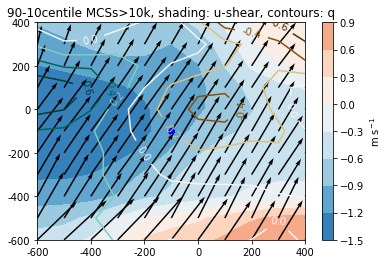

In [631]:
f = plt.figure()
ax = f.add_subplot(111)
plt.contourf((out_strong['u'].sel(level=600).values/cnt_strong[4,:,:])-(out_weak['u'].sel(level=600).values/cnt_weak[4,:,:]), cmap='RdBu_r', vmin=-2, vmax=2)
cbar = plt.colorbar()
cbar.set_label( 'm s$^{-1}$')
plt.title('90-10centile MCSs>10k, shading: u-shear, contours: q')
cs = plt.contour(((out_strong['q'].sel(level=925).values/cnt_strong[4,:,:])-(out_weak['q'].sel(level=925).values)/cnt_weak[4,:,:])*1000, cmap='BrBG', vmin=-0.5, vmax=0.5)
plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")
# qu = ax.quiver(xquiv, yquiv, u, v, scale=15)
# qk = plt.quiverkey(qu, 0.9, 0.02,1, '1 m s$^{-1}$',
#                    labelpos='E', coordinates='figure')
# plt.plot(5,5,'bo')
# ax.set_xticklabels([-600, -400, -200, 0, 200, 400, 600])
# ax.set_yticklabels([-600, -400, -200, 0, 200, 400, 600])
plt.savefig(cnst.network_data + 'figs/CLOVER/fig4.png')

[Text(0, 0, '-600'),
 Text(0, 0, '-400'),
 Text(0, 0, '-200'),
 Text(0, 0, '0'),
 Text(0, 0, '200'),
 Text(0, 0, '400')]

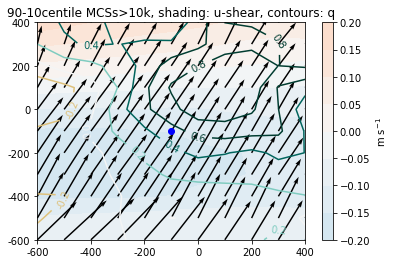

In [641]:
f = plt.figure()
ax = f.add_subplot(111)
plt.contourf((out_strong['u'].sel(level=600).values/cnt_strong[4,:,:])-(out_clim['u'].sel(level=600).values/cnt[4,:,:]), cmap='RdBu_r', vmin=-1, vmax=1)
cbar = plt.colorbar()
cbar.set_label( 'm s$^{-1}$')
plt.title('90-10centile MCSs>10k, shading: u-shear, contours: q')
cs = plt.contour(((out_weak['q'].sel(level=925).values/cnt_weak[4,:,:])-(out_clim['q'].sel(level=925).values)/cnt[4,:,:])*1000, cmap='BrBG', vmin=-0.5, vmax=0.5)
plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")
qu = ax.quiver(xquiv, yquiv, u, v, scale=15)
qk = plt.quiverkey(qu, 0.9, 0.02,1, '1 m s$^{-1}$',
                   labelpos='E', coordinates='figure')
plt.plot(5,5,'bo')
ax.set_xticklabels([-600, -400, -200, 0, 200, 400, 600])
ax.set_yticklabels([-600, -400, -200, 0, 200, 400, 600])

In [581]:
out_strong

<xarray.Dataset>
Dimensions:  (level: 6, x: 13, y: 13)
Coordinates:
  * level    (level) int32 600 650 700 850 925 950
Dimensions without coordinates: x, y
Data variables:
    pv       (level, y, x) float64 0.0002355 0.0002368 ... -0.001329 -0.001064
    t        (level, y, x) float64 7.256e+05 7.311e+05 ... 2.706e+06 2.691e+06
    q        (level, y, x) float64 12.69 12.82 12.87 12.9 ... 92.41 91.09 89.68
    w        (level, y, x) float64 -128.9 -124.8 -131.1 ... -341.1 -350.8 -338.4
    d        (level, y, x) float64 0.003611 0.003893 ... -0.03474 -0.0305
    r        (level, y, x) float64 1.754e+05 1.773e+05 ... 3.239e+05 3.185e+05
    u        (level, y, x) float64 -1.876e+04 -1.9e+04 ... -7.997e+03 -8.539e+03
    v        (level, y, x) float64 -1.66e+03 -1.726e+03 ... 1.93e+03 1.631e+03

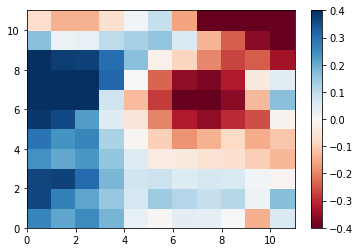

In [653]:
f = plt.figure()
d = (out_strong['q'].sel(level=925).values)/cnt_strong[0,:,:]
c = (out_weak['q'].sel(level=925).values)/cnt_weak[0,:,:]
clim = (out_clim['q'].sel(level=925).values)/cnt[0,:,:]
plt.pcolormesh((d-c)*1000, cmap='RdBu', vmin=-0.4, vmax=0.4)
plt.colorbar()


In [416]:
strong_u = ((out_strong['u'].sel(level=600).values/cnt[4,:,:] - out_strong['u'].sel(level=925).values)/cnt[4,:,:])
weak_u = ((out_weak['u'].sel(level=600).values/cnt[4,:,:] - out_weak['u'].sel(level=925).values)/cnt[4,:,:])
clim_u = ((out_ds['u'].sel(level=600).values/cnt[4,:,:] - out_ds['u'].sel(level=925).values)/cnt[4,:,:])

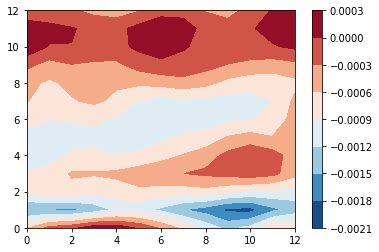

In [419]:
plt.contourf(weak_u, cmap='RdBu_r', )
plt.colorbar()

In [427]:
alls_q = out_ds['q'].sel(level=925).values  /cnt[0,:,:]
clim_q = out_clim['q'].sel(level=925).values /cnt[0,:,:]
strong_q = out_strong['q'].sel(level=925).values /cnt_strong[4,:,:]
weak_q = out_weak['q'].sel(level=925).values /cnt_weak[4,:,:]

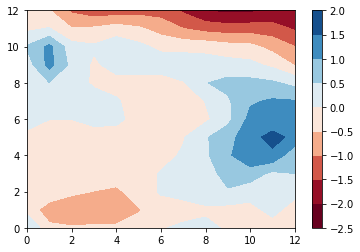

In [431]:
plt.contourf((strong_q-weak_q)*1000, cmap='RdBu', vmin=-2, vmax=2)
plt.colorbar()